# TVB-NEST: Bridging multiscale activity by co-simulation

## Step-by-step learn how to perform a co-simulation embedding spiking neural networks into large-scale brain networks using TVB.

In [1]:
from IPython.core.display import Image, display
display(Image(filename='./ConceptGraph1.png',  width=1000, unconfined=False))

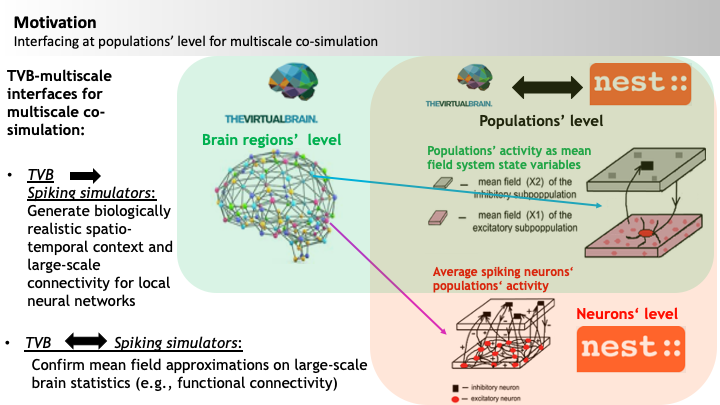

In [2]:
display(Image(filename='./ConceptGraph2.png',  width=1000, unconfined=False))

## tvb-multiscale toolbox:

### https://github.com/the-virtual-brain/tvb-multiscale

For questions use the git issue tracker, or write an e-mail to me: dionysios.perdikis@charite.de

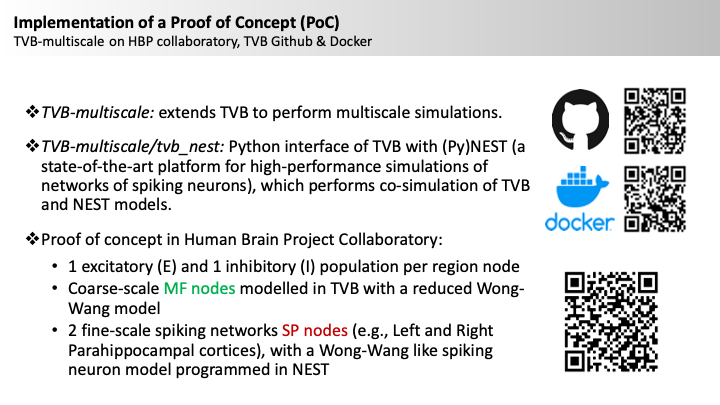

In [3]:
display(Image(filename='./Overview.png',  width=1000, unconfined=False))

# TVB - NEST co-simulation 

## Linear Reduced-Wong-Wang-like TVB mean field model

For every region node $n\prime$ modelled as a mean-field node in TVB:

(Post)Synaptic gating dynamics (i.e., proportion of synapse channels open at any given time):

$\dot{S_{n\prime}} = - \frac{1}{\tau}{S_{n\prime}}(t) + \gamma {R_{n\prime}}(t)$

(i.e., we have removed the nonlinearity $ (1-{S_{n\prime}}(t)) $ multiplying $ \gamma {R_{n\prime}}(t) $, in order to study the linear response of TVB)

and $ {R_{n\prime}}(t) $ is the postsynaptic firing rate given by:

$ {R_{n\prime}}(t) = H({I_{syn_{n\prime}}}(t), a, b, d) $

where

$ H({I_{syn_{n\prime}}}(t),  a, b, d) = \frac{aI_{syn_{n\prime}}(t)-b}{1-e^{-d(a{I_{syn_{n\prime}}}(t)-b)}}$ 

is a sigmoidal activation function of the input presynaptic current.

The total input presynaptic current to excitatory populations is given by: 

$ {I_{syn_{n\prime}}}(t) = I_o + w_+J_{N}{S_{n\prime}}(t) + GJ_{N}\sum_{{m\prime}\neq {n\prime}}C_{{m\prime}{n\prime}}S_{m\prime}(t-\tau_{{m\prime}{n\prime}})$

## Reduced Wong-Wang mean field model

### Parameters following Deco et al 2013:

- structural TVB connectivity weights $C_{{m\prime}{n\prime}}$ (${m\prime}->{n\prime}$)
- structural TVB connectivity delays $\tau_{{m\prime}{n\prime}}$  (${m\prime}->{n\prime}$)
- global structural brain connectivity coupling constant $G$
- overall effective external input current $I_o = 0.3nA$ 
- excitatory synaptic coupling $J_{N} = 0.2609nA$ 
- local excitatory recurrence $w_+ = 0.9$
- excitatory kinetic parameter $\gamma = 0.641 s$
- excitatory sigmoidal functions parameters $a = 2710nC^{-1}$, $b = 108Hz$, $d = 0.154s$


## Cerebellum Spiking network model in NEST

To be filled in!...

## TVB to NEST coupling
TVB couples to NEST via instantaneous spike rate $ interface_{weight} * R(t) $, 

Spike generator NEST devices are used as TVB "proxy" nodes and generate spike trains 

$ \left[ \sum_k \delta(t-\tau_{n\prime n}-{t_j}^k) \right]_{j \in n\prime} $



## NEST to TVB update

A NEST spike detector device is used to count spike for each time step, and convert it to an instantaneous population mean rate that overrides an auxiliary TVB state variables $R_{in}(t)$, which drives a linear integration equation of another auxiliary TVB state variable $R_{int}(t)$, which,in its turn, acts as a smoothing low pass filter:

$ \dot{R}_{int_{n}}  = -\frac{1}{\tau_{rin_{n}}}(R_{int_{n}}(t) - {R_{in_{n}}}(t)) $


where:

$ {R_{in_{n}}}(t) =  \frac{\sum_j\left[ \sum_k \delta(t-\tau_n-{t_j}^k) \right]_{j \in R_n}}{nNeurons * dt} $ in  spikes/sec.

Finally, $ {R_{int_{n}}}(t) $ overwrites the variable ${R_{n}}(t)$ via a user defined transform function:

${R_{n}}(t) = f_{NEST->TVB}({R_{int_{n}}}(t)) $

This update process concerns only the TVB region nodes that are simulated exclusively in NEST, as spiking networks. All the rest of TVB nodes will follow the equations of the mean field model described above.


## Simulator loop

### Simulating several (i.e., 4) NEST time steps for every 1 TVB time step for stable integration

In [4]:
from collections import OrderedDict
import time
import numpy as np

from tvb.basic.profile import TvbProfile
TvbProfile.set_profile(TvbProfile.LIBRARY_PROFILE)

from tvb_multiscale.tvb_nest.config import *
home_path = "/home/docker/packages/tvb-multiscale"
notebooks_path = os.path.join(home_path, "docs/documented_example_notebook")
config = Config(output_base=os.path.join(notebooks_path, "outputs_Cereb"))
config.figures.SHOW_FLAG = True 
config.figures.SAVE_FLAG = True
config.figures.FIG_FORMAT = 'png'
config.figures.DEFAULT_SIZE= config.figures.NOTEBOOK_SIZE
FIGSIZE = config.figures.DEFAULT_SIZE

from tvb_multiscale.core.plot.plotter import Plotter
plotter = Plotter(config.figures)

# For interactive plotting:
# %matplotlib notebook  

# Otherwise:
%matplotlib inline 

## 1. Load structural data <br> (minimally a TVB connectivity)  <br> & prepare TVB simulator  <br> (region mean field model, integrator, monitors etc)

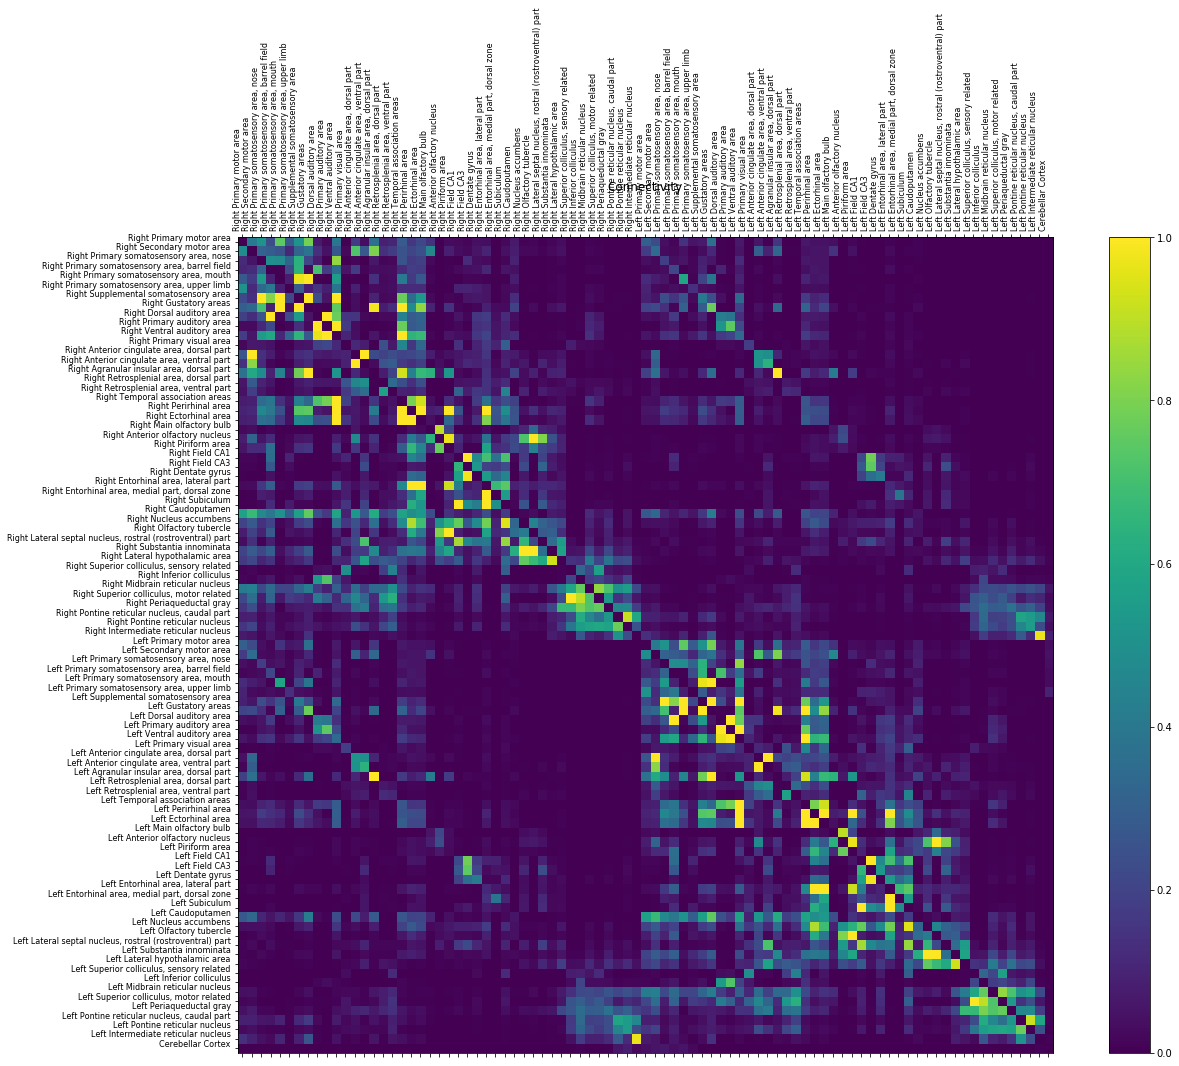

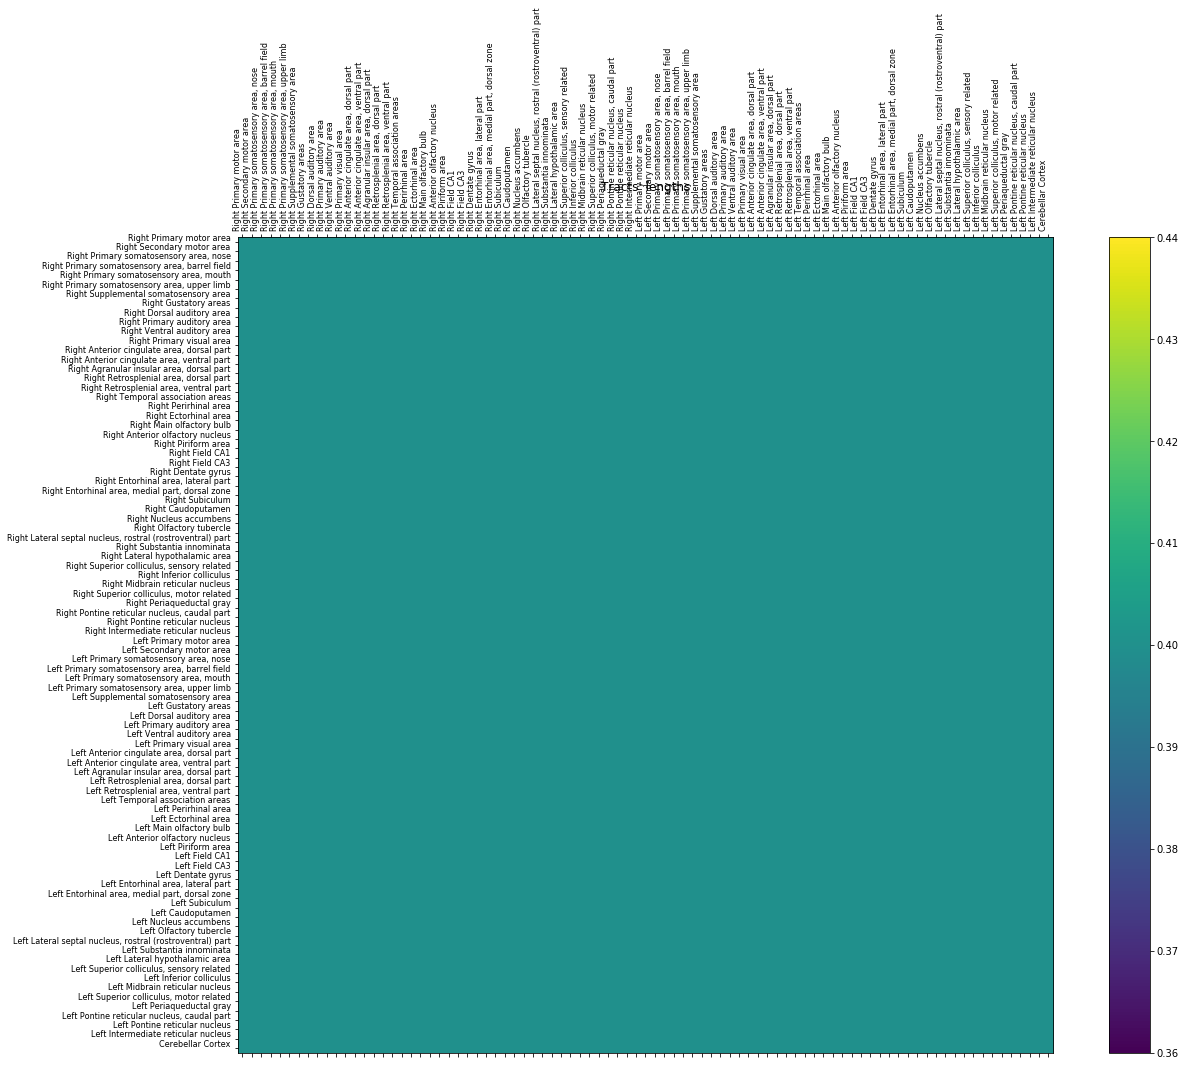

In [5]:
from tvb.simulator.models.linear_with_stimulus import Linear
from tvb.datatypes.connectivity import Connectivity
from tvb.simulator.cosimulator import CoSimulator
from tvb.simulator.integrators import HeunStochastic
from tvb.simulator.monitors import Raw  # , Bold, EEG


# Create a TVB simulator and set all desired inputs
# (connectivity, model, surface, stimuli etc)
# We choose all defaults in this example
simulator = CoSimulator()
model_params = {"I_o": np.array([0.0]), "G": np.array([16.0]), "tau": np.array([10.0]), "tau_rin": np.array([10.0])}
simulator.model = Linear(**model_params)

simulator.integrator = HeunStochastic()
simulator.integrator.dt = 0.1
simulator.integrator.noise.nsig = np.array([0.001])


# Load connectivity
# config.DEFAULT_CONNECTIVITY_ZIP = "/home/docker/packages/tvb_data/tvb_data/mouse/allen_2mm/ConnectivityAllen2mm.zip"                                  
# connectivity = Connectivity.from_file(config.DEFAULT_CONNECTIVITY_ZIP)
import os
DATA_PATH = os.path.join(home_path, "examples/tvb_nest/data")
w = np.loadtxt(os.path.join(DATA_PATH, "mouse_cereb_sum_weights.txt"))
# t = np.loadtxt(os.path.join(DATA_PATH, "tract_lengths_Count_plusCRBL.txt"))
# forcing one time step delay for all connections:
speed = 4.0
t = speed * simulator.integrator.dt * np.ones(w.shape)  
# brain_regions_path = os.path.join(DATA_PATH, "centres_brain_MNI.txt")
# rl = np.loadtxt(brain_regions_path,dtype="str", usecols=(0,))
with open(os.path.join(DATA_PATH, "mouse_cereb_regions_labels.txt"), "r") as text: 
    rl = [] 
    for line in text: 
        rl.append(line)
rl = np.array(rl)
# c = np.loadtxt(brain_regions_path, usecols=range(1,3))
c = np.random.uniform((w.shape[0], 3))
connectivity=Connectivity(region_labels=rl, weights=w, centres=c, tract_lengths=t)

# Normalize connectivity weights
connectivity.weights = connectivity.scaled_weights(mode="region")
connectivity.weights /= np.percentile(connectivity.weights, 99)
connectivity.weights[connectivity.weights > 1.0] = 1.0

connectivity.speed = np.array([speed])
connectivity.configure()

#white_matter_coupling = coupling.Linear(a=0.014)
simulator.connectivity = connectivity

simulator.model.I_o = simulator.model.I_o[0] * np.ones((simulator.connectivity.number_of_regions, ))

simulator.initial_conditions = np.zeros((2, 2, simulator.connectivity.number_of_regions, 1))

mon_raw = Raw(period=1.0)  # ms
simulator.monitors = (mon_raw, )

plotter.plot_tvb_connectivity(simulator.connectivity);

## 2. Build and connect the NEST network model <br> (networks of spiking neural populations for fine-scale <br>regions, stimulation devices, spike detectors etc)

In [6]:
# Select the regions for the fine scale modeling with NEST spiking networks
nest_nodes_ids = []
for i_region, reg_lbl in enumerate(simulator.connectivity.region_labels):
    if "cereb" in reg_lbl.lower():
        nest_nodes_ids.append(i_region)  # the indices of fine scale regions modeled with NEST
if len(nest_nodes_ids) == 0:
    nest_nodes_ids = [simulator.connectivity.number_of_regions-1]

print(["%d. %s" % (nest_node_id, simulator.connectivity.region_labels[nest_node_id]) for nest_node_id in nest_nodes_ids])


['86. Cerebellar Cortex\n']


In [7]:
connections_to_cereb = simulator.connectivity.weights[:, nest_nodes_ids[0]]
sorted_connections_to_cereb = np.argsort(connections_to_cereb)[::-1]
print("sorted_connections_to_cereb =\n") 
for conn_id in sorted_connections_to_cereb:
    print("\n%d. %s, w = %g" % 
          (conn_id, simulator.connectivity.region_labels[conn_id], connections_to_cereb[conn_id]))
connections_from_cereb = simulator.connectivity.weights[nest_nodes_ids[0], :]
sorted_connections_from_cereb = np.argsort(connections_from_cereb)[::-1]
print("sorted_connections_from_cereb =\n") 
for conn_id in sorted_connections_from_cereb:
    print("\n%d. %s, w = %g" % 
          (conn_id, simulator.connectivity.region_labels[conn_id], connections_from_cereb[conn_id]))

sorted_connections_to_cereb =


48. Left Primary somatosensory area, upper limb
, w = 0.0932998

42. Right Intermediate reticular nucleus
, w = 0.0880885

40. Right Pontine reticular nucleus, caudal part
, w = 0.0636727

37. Right Midbrain reticular nucleus
, w = 0.0546067

44. Left Secondary motor area
, w = 0.0496462

41. Right Pontine reticular nucleus
, w = 0.0425532

45. Left Primary somatosensory area, nose
, w = 0.0414891

43. Left Primary motor area
, w = 0.0386569

39. Right Periaqueductal gray
, w = 0.031503

47. Left Primary somatosensory area, mouth
, w = 0.029014

46. Left Primary somatosensory area, barrel field
, w = 0.0285768

38. Right Superior colliculus, motor related
, w = 0.0242839

36. Right Inferior colliculus
, w = 0.0100387

85. Left Intermediate reticular nucleus
, w = 0.0100387

34. Right Lateral hypothalamic area
, w = 0.00874441

83. Left Pontine reticular nucleus, caudal part
, w = 0.00874441

33. Right Substantia innominata
, w = 0.00532426

82. Left Peri

In [8]:
stim_node_id = 42
print("TVB stimulus to %d. Right Intermediate reticular nucleus, w = %g" % 
      (stim_node_id, connections_to_cereb[stim_node_id]))
connections_from_stim = simulator.connectivity.weights[stim_node_id, :]
sorted_connections_from_stim = np.argsort(connections_from_stim)[::-1]
print("which connects to...")
print("sorted_connections_from 42. Right Intermediate reticular nucleus =\n") 
for conn_id in sorted_connections_from_stim:
    print("\n%d. %s, w = %g" % 
          (conn_id, simulator.connectivity.region_labels[conn_id], connections_from_stim[conn_id]))


TVB stimulus to 42. Right Intermediate reticular nucleus, w = 0.0880885
which connects to...
sorted_connections_from 42. Right Intermediate reticular nucleus =


85. Left Intermediate reticular nucleus
, w = 0.968941

40. Right Pontine reticular nucleus, caudal part
, w = 0.508016

83. Left Pontine reticular nucleus, caudal part
, w = 0.280905

36. Right Inferior colliculus
, w = 0.267882

50. Left Gustatory areas
, w = 0.266632

41. Right Pontine reticular nucleus
, w = 0.235505

79. Left Inferior colliculus
, w = 0.178339

7. Right Gustatory areas
, w = 0.143117

39. Right Periaqueductal gray
, w = 0.141712

43. Left Primary motor area
, w = 0.133181

82. Left Periaqueductal gray
, w = 0.124646

84. Left Pontine reticular nucleus
, w = 0.118945

47. Left Primary somatosensory area, mouth
, w = 0.102337

37. Right Midbrain reticular nucleus
, w = 0.0986773

81. Left Superior colliculus, motor related
, w = 0.0892957

44. Left Secondary motor area
, w = 0.0888689

80. Left Midbrain ret

In [9]:
# Build a NEST network model with the corresponding builder
from tvb_multiscale.tvb_nest.nest_models.builders.models.cereb import CerebBuilder

# Using all default parameters for this example
nest_model_builder = CerebBuilder(simulator, nest_nodes_ids, 
                                  os.path.join(DATA_PATH, "cerebellar_cortex_scaffold_dcn.hdf5"),
                                  config=config)
nest_model_builder.modules_to_install = ["cereb"]

# or...

# # ----------------------------------------------------------------------------------------------------------------
# # ----Uncomment below to modify the builder by changing the default  builder configuration------------------------
# # ----------------------------------------------------------------------------------------------------------------
# import h5py

# # Synapse parameters: in E-GLIF, 3 synaptic receptors are present:
# # the first is always associated to exc,
# # the second to inh,
# # the third to remaining synapse type
# Erev_exc = 0.0  # [mV]	# [Cavallari et al, 2014]
# Erev_inh = -80.0  # [mV]
# # tau_exc for pc is for pf input; tau_exc for goc is for mf input; tau_exc for mli is for pf input:
# tau_exc = {'golgi': 0.23, 'granule': 5.8, 'purkinje': 1.1, 'basket': 0.64, 'stellate': 0.64, 'dcn': 1.0,
#            'dcnp': 3.64,
#            'io': 1.0}
# tau_inh = {'golgi': 10.0, 'granule': 13.61, 'purkinje': 2.8, 'basket': 2.0, 'stellate': 2.0, 'dcn': 0.7,
#            'dcnp': 1.14, 'io': 60.0}
# tau_exc_cfpc = 0.4
# tau_exc_pfgoc = 0.5
# tau_exc_cfmli = 1.2

# # Single neuron parameters:
# nest_model_builder.neuron_param = {
#         'golgi_cell': {'t_ref': 2.0, 'C_m': 145.0, 'tau_m': 44.0, 'V_th': -55.0, 'V_reset': -75.0, 'Vinit': -62.0,
#                        'E_L': -62.0, 'Vmin': -150.0,
#                        'lambda_0': 1.0, 'tau_V': 0.4, 'I_e': 16.214, 'kadap': 0.217, 'k1': 0.031, 'k2': 0.023,
#                        'A1': 259.988, 'A2': 178.01,
#                        'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc, 'tau_syn1': tau_exc['golgi'],
#                        'tau_syn2': tau_inh['golgi'], 'tau_syn3': tau_exc_pfgoc},
#         'granule_cell': {'t_ref': 1.5, 'C_m': 7.0, 'tau_m': 24.15, 'V_th': -41.0, 'V_reset': -70.0, 'Vinit': -62.0,
#                          'E_L': -62.0, 'Vmin': -150.0,
#                          'lambda_0': 1.0, 'tau_V': 0.3, 'I_e': -0.888, 'kadap': 0.022, 'k1': 0.311, 'k2': 0.041,
#                          'A1': 0.01, 'A2': -0.94,
#                          'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc, 'tau_syn1': tau_exc['granule'],
#                          'tau_syn2': tau_inh['granule'], 'tau_syn3': tau_exc['granule']},
#         'purkinje_cell': {'t_ref': 0.5, 'C_m': 334.0, 'tau_m': 47.0, 'V_th': -43.0, 'V_reset': -69.0, 'Vinit': -59.0,
#                           'E_L': -59.0,
#                           'lambda_0': 4.0, 'tau_V': 3.5, 'I_e': 742.54, 'kadap': 1.492, 'k1': 0.1950, 'k2': 0.041,
#                           'A1': 157.622, 'A2': 172.622,
#                           'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc, 'tau_syn1': tau_exc['purkinje'],
#                           'tau_syn2': tau_inh['purkinje'], 'tau_syn3': tau_exc_cfpc},
#         'basket_cell': {'t_ref': 1.59, 'C_m': 14.6, 'tau_m': 9.125, 'V_th': -53.0, 'V_reset': -78.0, 'Vinit': -68.0,
#                         'E_L': -68.0,
#                         'lambda_0': 1.8, 'tau_V': 1.1, 'I_e': 3.711, 'kadap': 2.025, 'k1': 1.887, 'k2': 1.096,
#                         'A1': 5.953, 'A2': 5.863,
#                         'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc, 'tau_syn1': tau_exc['basket'],
#                         'tau_syn2': tau_inh['basket'], 'tau_syn3': tau_exc_cfmli},
#         'stellate_cell': {'t_ref': 1.59, 'C_m': 14.6, 'tau_m': 9.125, 'V_th': -53.0, 'V_reset': -78.0, 'Vinit': -68.0,
#                           'E_L': -68.0,
#                           'lambda_0': 1.8, 'tau_V': 1.1, 'I_e': 3.711, 'kadap': 2.025, 'k1': 1.887, 'k2': 1.096,
#                           'A1': 5.953, 'A2': 5.863,
#                           'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc, 'tau_syn1': tau_exc['basket'],
#                           'tau_syn2': tau_inh['basket'], 'tau_syn3': tau_exc_cfmli},
#         'dcn_cell': {'t_ref': 0.8, 'C_m': 142.0,'tau_m': 33.0,'V_th': -36.0,'V_reset': -55.0,'Vinit': -45.0,'E_L': -45.0,
#                          'lambda_0':3.5, 'tau_V':3.0,'I_e': 75.385,'kadap': 0.408,'k1': 0.697, 'k2': 0.047,'A1': 13.857,'A2':3.477,
#                          'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc,'tau_syn1': tau_exc['dcn'], 'tau_syn2': tau_inh['dcn']}}

# # Connection weights
# nest_model_builder.conn_weights = {'mossy_to_glomerulus': 1.0, 'ascending_axon_to_golgi': 0.05, 'ascending_axon_to_purkinje': 0.175,
#                     'basket_to_purkinje': 3.638,
#                     'glomerulus_to_golgi': 0.0125, 'glomerulus_to_granule': 0.361, 'golgi_to_granule': 0.338,
#                     'parallel_fiber_to_basket': 0.002, 'parallel_fiber_to_golgi': 0.008,
#                     'parallel_fiber_to_purkinje': 0.044,
#                     'parallel_fiber_to_stellate': 0.003, 'stellate_to_purkinje': 1.213, 
#                     'mossy_to_dcn': 0.5, 'purkinje_to_dcn': 0.45}

# # Connection delays
# nest_model_builder.conn_delays = \
#     {'mossy_to_glomerulus': 1.0, 'ascending_axon_to_golgi': 2.0, 'ascending_axon_to_purkinje': 2.0,
#      'basket_to_purkinje': 4.0, 'glomerulus_to_golgi': 4.0, 'glomerulus_to_granule': 4.0, 'golgi_to_granule': 2.0,
#      'parallel_fiber_to_basket': 5.0, 'parallel_fiber_to_golgi': 5.0, 'parallel_fiber_to_purkinje': 5.0,
#      'parallel_fiber_to_stellate': 5.0, 'stellate_to_purkinje': 5.0, 
#      'mossy_to_dcn': 4.0, 'purkinje_to_dcn': 4.0}

# # Connection receptors
# nest_model_builder.conn_receptors = \
#     {'ascending_axon_to_golgi': 3, 'ascending_axon_to_purkinje': 1, 'basket_to_purkinje': 2,
#      'glomerulus_to_golgi': 1, 'glomerulus_to_granule': 1, 'golgi_to_granule': 2,
#      'parallel_fiber_to_basket': 1, 'parallel_fiber_to_golgi': 3, 'parallel_fiber_to_purkinje': 1,
#      'parallel_fiber_to_stellate': 1, 'stellate_to_purkinje': 2, 
#      'mossy_to_dcn': 1, 'purkinje_to_dcn': 2}

# # Connection pre and post-synaptic neurons
# nest_model_builder.conn_pre_post = \
#     {'mossy_to_glomerulus': {'pre': 'mossy_fibers', 'post': 'glomerulus'},
#      'ascending_axon_to_golgi': {'pre': 'granule_cell', 'post': 'golgi_cell'},
#      'ascending_axon_to_purkinje': {'pre': 'granule_cell', 'post': 'purkinje_cell'},
#      'basket_to_purkinje': {'pre': 'basket_cell', 'post': 'purkinje_cell'},
#      'glomerulus_to_golgi': {'pre': 'glomerulus', 'post': 'golgi_cell'},
#      'glomerulus_to_granule': {'pre': 'glomerulus', 'post': 'granule_cell'},
#      'golgi_to_granule': {'pre': 'golgi_cell', 'post': 'granule_cell'},
#      'parallel_fiber_to_basket': {'pre': 'granule_cell', 'post': 'basket_cell'},
#      'parallel_fiber_to_golgi': {'pre': 'granule_cell', 'post': 'golgi_cell'},
#      'parallel_fiber_to_purkinje': {'pre': 'granule_cell', 'post': 'purkinje_cell'},
#      'parallel_fiber_to_stellate': {'pre': 'granule_cell', 'post': 'stellate_cell'},
#      'stellate_to_purkinje': {'pre': 'stellate_cell', 'post': 'purkinje_cell'}, 
#      'purkinje_to_dcn': {'pre': 'purkinje_cell', 'post': 'dcn_cell'}}

# nest_model_builder.RECORD_VM = True
# nest_model_builder.TOT_DURATION = 350.  # 350 mseconds
# nest_model_builder.STIM_START = 150.  # 150 beginning of stimulation
# nest_model_builder.STIM_END = 250.  # 250 end of stimulation
# nest_model_builder.STIM_FREQ = 100.  # Frequency in Hz
# nest_model_builder.BACKGROUND_FREQ = 4.

# # Load the network source file:
# nest_model_builder.net_src_file = h5py.File(nest_model_builder.path_to_network_source_file, 'r+')

# # Populations' configurations
# nest_model_builder.neuron_types = list(nest_model_builder.net_src_file['cells/placement'].keys())
# ordered_neuron_types = []
# nest_model_builder.ordered_neuron_types = ['mossy_fibers', 'glomerulus', "granule_cell", "golgi_cell",
#                                            "basket_cell", "stellate_cell", "purkinje_cell", "dcn_cell"]
# for neuron_type in nest_model_builder.ordered_neuron_types:
#     ordered_neuron_types.append(
#         nest_model_builder.neuron_types.pop(
#             nest_model_builder.neuron_types.index(neuron_type)))
# ordered_neuron_types += nest_model_builder.neuron_types
# nest_model_builder.neuron_types = ordered_neuron_types

# nest_model_builder.populations = []
# nest_model_builder.start_id_scaffold = {}
# # All cells are modelled as E-GLIF models;
# # with the only exception of Glomeruli and Mossy Fibers (not cells, just modeled as
# # relays; i.e., parrot neurons)
# for neuron_name in nest_model_builder.neuron_types:
#     if neuron_name != 'glomerulus' and neuron_name != 'mossy_fibers':
#         model = 'eglif_cond_alpha_multisyn'
#     else:
#         model = 'parrot_neuron'
#     n_neurons = np.array(nest_model_builder.net_src_file['cells/placement/' + neuron_name + '/identifiers'])[1]
#     nest_model_builder.populations.append(
#                 {"label": neuron_name, "model": model,
#                  "params": nest_model_builder.neuron_param.get(neuron_name, {}),
#                  "scale": n_neurons,
#                  "nodes": None})
#     nest_model_builder.start_id_scaffold[neuron_name] = \
#                 np.array(nest_model_builder.net_src_file['cells/placement/' + neuron_name + '/identifiers'])[0]

# class NeuronsIndsFun(object):
#     conns = np.array([])
#     start_id_scaffold = 0

#     def __init__(self, start_id_scaffold, conns):
#         self.start_id_scaffold = start_id_scaffold
#         self.conns = conns

#     def __call__(self, neurons_inds):
#         return [int(x - self.start_id_scaffold + neurons_inds[0])
#                 for x in self.conns]
    
# # Within brain regions' nodes connections among populations:
# nest_model_builder.default_populations_connection["conn_spec"]["rule"] = "one_to_one"
# nest_model_builder.populations_connections = []
# for conn_name in nest_model_builder.conn_weights.keys():
#     conn = np.array(nest_model_builder.net_src_file['cells/connections/'+conn_name])
#     pre_name = nest_model_builder.conn_pre_post[conn_name]["pre"]
#     post_name = nest_model_builder.conn_pre_post[conn_name]["post"]
#     nest_model_builder.populations_connections.append(
#         {"source": pre_name, "target": post_name,
#          "source_inds": NeuronsIndsFun(nest_model_builder.start_id_scaffold[pre_name], conn[:, 0].flatten()),
#          "target_inds": NeuronsIndsFun(nest_model_builder.start_id_scaffold[post_name], conn[:, 1].flatten()),
#          "model": 'static_synapse',
#          "conn_spec": nest_model_builder.default_populations_connection["conn_spec"],
#          "weight": nest_model_builder.conn_weights[conn_name],
#          "delay": nest_model_builder.conn_delays[conn_name],
#          "receptor_type": nest_model_builder.conn_receptors.get(conn_name, 0),
#          "nodes": None
#         }
#     )

# # No among brain region regions' nodes' connectivity yet for the NEST Cerebellum network! 
# # Assuming a single Cerebellum region.

# # We don't need the network source file any more. Close it:
# nest_model_builder.net_src_file.close()

# def neurons_inds_fun(neurons_inds, n_neurons=100):
#     # We use this in order to measure up to n_neurons neurons from every population
#     n_neurons_inds = len(neurons_inds)
#     if n_neurons_inds > n_neurons:
#         return tuple(np.array(neurons_inds)[0:-1:int(np.ceil(1.0*n_neurons_inds/n_neurons))])
#     else:
#         return neurons_inds
    
# # Output Devices:
# nest_model_builder.output_devices = []
# # Spike detectors:
# connections = OrderedDict()
# #          label <- target population
# for pop in nest_model_builder.populations:
#     connections[pop["label"] + "_spikes"] = pop["label"]
#     params = dict(nest_model_builder.config.NEST_OUTPUT_DEVICES_PARAMS_DEF["spike_detector"])
#     nest_model_builder.output_devices.append(
#         {"model": "spike_detector", "params": params,
#          "connections": connections, "nodes": None})  # None means all here

# if nest_model_builder.RECORD_VM:    
#     # Multimeters:
#     connections = OrderedDict()
#     #               label    <- target population
#     for pop in nest_model_builder.populations:
#         if pop["label"] != 'glomerulus' and pop["label"] != 'mossy_fibers':
#             connections[pop["label"]] = pop["label"]
#         params = dict(nest_model_builder.config.NEST_OUTPUT_DEVICES_PARAMS_DEF["multimeter"])
#         params["interval"] = nest_model_builder.monitor_period
#         nest_model_builder.output_devices.append(
#                 {"model": "multimeter", "params": params,
#                  "neurons_inds": lambda node, neurons_inds: neurons_inds_fun(neurons_inds),
#                  "connections": connections, "nodes": None})  # None means all here
    
# # Input (stimulus) Devices (needed only when there is no TVB input to the Cerebellum):
# nest_model_builder.input_devices = []
# # # Background spike stimulus :
# # connections = OrderedDict()
# # #             label <- target population
# # connections["Background"] = ['mossy_fibers']
# # nest_model_builder.input_devices.append(
# #     {"model": "poisson_generator",
# #      "params": {"rate": nest_model_builder.BACKGROUND_FREQ, 
# #                 "origin": 0.0, "start": 0.0}, # not necessary: "stop": nest_model_builder.TOT_DURATION
# #      "connections": connections, "nodes": None,
# #      "weights": 1.0, "delays": 0.0, "receptor_type": 0})
# # # Spike stimulus 
# # connections = OrderedDict()
# # #             label <- target population
# # connections["Stimulus"] = ['mossy_fibers']
# # nest_model_builder.input_devices.append(
# #     {"model": "poisson_generator",
# #      "params": {"rate": nest_model_builder.STIM_FREQ, "origin": 0.0, 
# #                 "start": nest_model_builder.STIM_START, "stop": nest_model_builder.STIM_END},
# #      "connections": connections, "nodes": None,
# #      "weights": 1.0, "delays": 0.0, "receptor_type": 0})

# # ----------------------------------------------------------------------------------------------------------------
# # ----------------------------------------------------------------------------------------------------------------
# # ----------------------------------------------------------------------------------------------------------------


# nest_network = nest_model_builder.build_spiking_network()


# or build the network without using the TVB-NEST NEST network builder...:


# ----------------------------------------------------------------------------------------------------------------
# ----Uncomment below to build the NEST network without using the NEST model builder of TVB-NEST------------------
# ----------------------------------------------------------------------------------------------------------------
import h5py
!rm *.gdf
!rm *.dat

nest_model_builder.compile_install_nest_modules(["cereb"])

# Synapse parameters: in E-GLIF, 3 synaptic receptors are present: the first is always associated to exc, the second to inh, the third to remaining synapse type
Erev_exc = 0.0		# [mV]	#[Cavallari et al, 2014]
Erev_inh = -80.0		# [mV]
tau_exc = {'golgi': 0.23, 'granule': 5.8, 'purkinje': 1.1, 'basket': 0.64, 'stellate': 0.64, 'dcn': 1.0, 'dcnp': 3.64, 'io': 1.0}		#tau_exc for pc is for pf input; tau_exc for goc is for mf input; tau_exc for mli is for pf input
tau_inh = {'golgi': 10.0, 'granule': 13.61, 'purkinje': 2.8, 'basket': 2.0, 'stellate': 2.0, 'dcn': 0.7, 'dcnp': 1.14, 'io': 60.0}
tau_exc_cfpc = 0.4
tau_exc_pfgoc = 0.5
tau_exc_cfmli = 1.2

# Single neuron parameters:
neuron_param = {'golgi_cell': {'t_ref': 2.0, 'C_m': 145.0,'tau_m': 44.0,'V_th': -55.0,'V_reset': -75.0,'Vinit': -62.0,'E_L': -62.0,'Vmin':-150.0,
                         'lambda_0':1.0, 'tau_V':0.4,'I_e': 16.214,'kadap': 0.217,'k1': 0.031, 'k2': 0.023,'A1': 259.988,'A2':178.01,
                         'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc,'tau_syn1': tau_exc['golgi'], 'tau_syn2': tau_inh['golgi'], 'tau_syn3': tau_exc_pfgoc},
               'granule_cell': {'t_ref': 1.5, 'C_m': 7.0,'tau_m': 24.15,'V_th': -41.0,'V_reset': -70.0,'Vinit': -62.0,'E_L': -62.0,'Vmin': -150.0,
                           'lambda_0':1.0, 'tau_V':0.3,'I_e': -0.888,'kadap': 0.022,'k1': 0.311, 'k2': 0.041,'A1': 0.01,'A2':-0.94,
                           'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc,'tau_syn1': tau_exc['granule'], 'tau_syn2': tau_inh['granule'], 'tau_syn3': tau_exc['granule']},
               'purkinje_cell': {'t_ref': 0.5, 'C_m': 334.0,'tau_m': 47.0,'V_th': -43.0,'V_reset': -69.0,'Vinit': -59.0,'E_L': -59.0,
                            'lambda_0':4.0, 'tau_V':3.5,'I_e': 742.54,'kadap': 1.492,'k1': 0.1950, 'k2': 0.041,'A1': 157.622,'A2':172.622,
                            'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc,'tau_syn1': tau_exc['purkinje'], 'tau_syn2': tau_inh['purkinje'], 'tau_syn3': tau_exc_cfpc},
               'basket_cell': {'t_ref': 1.59, 'C_m': 14.6,'tau_m': 9.125,'V_th': -53.0,'V_reset': -78.0,'Vinit': -68.0,'E_L': -68.0,
                          'lambda_0':1.8, 'tau_V':1.1,'I_e': 3.711,'kadap': 2.025,'k1': 1.887, 'k2': 1.096,'A1': 5.953,'A2':5.863,
                          'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc,'tau_syn1': tau_exc['basket'], 'tau_syn2': tau_inh['basket'], 'tau_syn3': tau_exc_cfmli},
               'stellate_cell': {'t_ref': 1.59, 'C_m': 14.6,'tau_m': 9.125,'V_th': -53.0,'V_reset': -78.0,'Vinit': -68.0,'E_L': -68.0,
                            'lambda_0':1.8, 'tau_V':1.1,'I_e': 3.711,'kadap': 2.025,'k1': 1.887, 'k2': 1.096,'A1': 5.953,'A2':5.863,
                            'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc,'tau_syn1': tau_exc['basket'], 'tau_syn2': tau_inh['basket'], 'tau_syn3': tau_exc_cfmli},
               'dcn_cell': {'t_ref': 0.8, 'C_m': 142.0,'tau_m': 33.0,'V_th': -36.0,'V_reset': -55.0,'Vinit': -45.0,'E_L': -45.0,
                         'lambda_0':3.5, 'tau_V':3.0,'I_e': 75.385,'kadap': 0.408,'k1': 0.697, 'k2': 0.047,'A1': 13.857,'A2':3.477,
                         'E_rev1': Erev_exc, 'E_rev2': Erev_inh, 'E_rev3': Erev_exc,'tau_syn1': tau_exc['dcn'], 'tau_syn2': tau_inh['dcn']}}


# Connection weights
conn_weights = {'mossy_to_glomerulus': 1.0,'ascending_axon_to_golgi': 0.05, 'ascending_axon_to_purkinje': 0.175, 'basket_to_purkinje': 3.638,\
                'glomerulus_to_golgi': 0.0125, 'glomerulus_to_granule': 0.361, 'golgi_to_granule': 0.338,\
                'parallel_fiber_to_basket': 0.002, 'parallel_fiber_to_golgi': 0.008,'parallel_fiber_to_purkinje': 0.044,\
                'parallel_fiber_to_stellate': 0.003, 'stellate_to_purkinje': 1.213,\
                'mossy_to_dcn': 0.5, 'purkinje_to_dcn': 0.45}


# Connection delays
conn_delays = {'mossy_to_glomerulus': 1.0,'ascending_axon_to_golgi': 2.0, 'ascending_axon_to_purkinje': 2.0, 'basket_to_purkinje': 4.0,
               'glomerulus_to_golgi': 4.0, 'glomerulus_to_granule': 4.0, 'golgi_to_granule': 2.0,
               'parallel_fiber_to_basket': 5.0, 'parallel_fiber_to_golgi': 5.0,'parallel_fiber_to_purkinje': 5.0,
               'parallel_fiber_to_stellate': 5.0, 'stellate_to_purkinje':5.0,\
               'mossy_to_dcn': 4.0, 'purkinje_to_dcn': 4.0}

# Connection receptors
conn_receptors = {'ascending_axon_to_golgi': 3, 'ascending_axon_to_purkinje': 1, 'basket_to_purkinje': 2,
               'glomerulus_to_golgi': 1, 'glomerulus_to_granule': 1, 'golgi_to_granule': 2,
               'parallel_fiber_to_basket': 1, 'parallel_fiber_to_golgi': 3,'parallel_fiber_to_purkinje': 1,
               'parallel_fiber_to_stellate': 1, 'stellate_to_purkinje': 2, \
               'mossy_to_dcn': 1, 'purkinje_to_dcn': 2}


# Connection pre and post-synaptic neurons
conn_pre_post = {'mossy_to_glomerulus': {'pre': 'mossy_fibers', 'post': 'glomerulus'},\
                 'ascending_axon_to_golgi': {'pre': 'granule_cell', 'post': 'golgi_cell'},\
                 'ascending_axon_to_purkinje': {'pre': 'granule_cell', 'post': 'purkinje_cell'},\
                 'basket_to_purkinje': {'pre': 'basket_cell', 'post': 'purkinje_cell'},\
                 'glomerulus_to_golgi': {'pre': 'glomerulus', 'post': 'golgi_cell'}, \
                 'glomerulus_to_granule': {'pre': 'glomerulus', 'post': 'granule_cell'}, \
                 'golgi_to_granule': {'pre': 'golgi_cell', 'post': 'granule_cell'},\
                 'parallel_fiber_to_basket': {'pre': 'granule_cell', 'post': 'basket_cell'}, \
                 'parallel_fiber_to_golgi': {'pre': 'granule_cell', 'post': 'golgi_cell'},\
                 'parallel_fiber_to_purkinje': {'pre': 'granule_cell', 'post': 'purkinje_cell'},\
                 'parallel_fiber_to_stellate': {'pre': 'granule_cell', 'post': 'stellate_cell'}, \
                 'stellate_to_purkinje': {'pre': 'stellate_cell', 'post': 'purkinje_cell'},\
                 'mossy_to_dcn': {'pre': 'mossy_fibers', 'post': 'dcn_cell'},\
                 'purkinje_to_dcn': {'pre': 'purkinje_cell', 'post': 'dcn_cell'}}


# Get the nest instance of the NEST model builder:
nest = nest_model_builder.nest_instance
nest_model_builder._configure_nest_kernel()

# Prepare the NEST kernel:
# nest.ResetKernel()
# nest.set_verbosity('M_ERROR')
# nest.SetKernelStatus({"local_num_threads" : cpu_count()})

# Load the network source file:
f = h5py.File(nest_model_builder.path_to_network_source_file, 'r+')

neuron_types = list(f['cells/placement'].keys())
ordered_neuron_types = []
for neuron_type in ['mossy_fibers', 'glomerulus', "granule_cell", "golgi_cell", 
                    "basket_cell", "stellate_cell", "purkinje_cell"]:
    ordered_neuron_types.append(neuron_types.pop(neuron_types.index(neuron_type)))
ordered_neuron_types += neuron_types
neuron_types = ordered_neuron_types
print(neuron_types)

neuron_number = {}
start_id_scaffold = {}

# ### Creating population of neurons
# Instantiate conductance based Extended-Generalized Leaky Integrate and Fire models (E-GLIF) for each cell type. 
# The only exception is represented by Glomeruli and Mossy Fibers; these are not actual cells but just 'relays', 
# used to deliver input spikes to other cells. Here, Glomeruli are created as *parrot_neurons*

# Create a dictionary; keys = cell names, values = lists to store neuron models
neuron_models = {key: [] for key in neuron_types}

# All cells are modelled as E-GLIF models;
# with the only exception of Glomeruli and Mossy Fibers (not cells, just modeled as
# relays; i.e., parrot neurons)
from tvb_multiscale.tvb_nest.nest_models.brain import NESTBrain
from tvb_multiscale.tvb_nest.nest_models.region_node import NESTRegionNode
from tvb_multiscale.tvb_nest.nest_models.population import NESTPopulation
nest_region_label = simulator.connectivity.region_labels[nest_nodes_ids[0]]
nest_brain = NESTBrain(nest_instance=nest)
nest_brain[nest_region_label] = NESTRegionNode(label=nest_region_label, nest_instance=nest)
for neuron_name in neuron_types:
    if neuron_name  != 'glomerulus' and neuron_name != 'mossy_fibers':
        if neuron_name not in nest.Models():
            model = 'eglif_cond_alpha_multisyn'
            nest.CopyModel('eglif_cond_alpha_multisyn', neuron_name)
            nest.SetDefaults(neuron_name, neuron_param[neuron_name])
    else:
        model = 'parrot_neuron'
        if neuron_name not in nest.Models():
            nest.CopyModel('parrot_neuron', neuron_name)
    
    neuron_number[neuron_name] = np.array(f['cells/placement/'+neuron_name+'/identifiers'])[1]
    start_id_scaffold[neuron_name] = np.array(f['cells/placement/'+neuron_name+'/identifiers'])[0]
    
    neuron_models[neuron_name] = nest.Create(neuron_name, neuron_number[neuron_name])
    
    # Set the neurons' indices into a NESTPopulation class instance inside the NESTBrain class instance:
    nest_brain[nest_region_label][neuron_name] = NESTPopulation(neuron_models[neuron_name],
                                                                label=neuron_name, model=model, 
                                                                nest_instance=nest)

    
# ### Creating synaptic connections
# Here we create synaptic connections among neurons. 
# A message will be printed below the next cell when each connection type is done:

### Load connections from hdf5 file and create them in NEST:
for conn in conn_weights.keys():
    conn_name = conn
    conn = np.array(f['cells/connections/'+conn_name])
    pre_name = conn_pre_post[conn_name]["pre"]
    post_name = conn_pre_post[conn_name]["post"]
    pre = [int(x-start_id_scaffold[pre_name]+neuron_models[pre_name][0]) for x in conn[:,0]]
    post = [int(x-start_id_scaffold[post_name]+neuron_models[post_name][0]) for x in conn[:,1]]
    if conn_name=="mossy_to_glomerulus":
        syn_param = {"model": "static_synapse", "weight": conn_weights[conn_name], "delay": conn_delays[conn_name]}
    else:
        syn_param = {"model": "static_synapse", "weight": conn_weights[conn_name], "delay": conn_delays[conn_name],"receptor_type":conn_receptors[conn_name]}
    nest.Connect(pre, post, {"rule": "one_to_one"}, syn_param)
    print("Connections ", conn_name, " done!")

    
from pandas import Series
from tvb_multiscale.core.spiking_models.devices import DeviceSet
from tvb_multiscale.tvb_nest.nest_models.devices import NESTPoissonGenerator, NESTSpikeDetector, NESTMultimeter

input_devices = Series()

# ### Defining stimuli (needed only when there is no TVB input to the Cerebellum)
# Into the next cell, the user can define the parameters value for the simulation. The background input is a 4 Hz Poisson process to glomeruli, for 300 ms. Then a 100-Hz burst is provided, lasting 100 ms. The user can set the following parameters:
# 1. RECORD_VM: by default, spike data are recorded. If you want to record voltage-traces too, please set this variable to 'True', but consider that this is going to increase the computational time of the simulation.
# 2. TOT_DURATION: duration of whole simulation, in milliseconds. 
# 3. STIM_START: when the burst (a Poisson process spike train) should start.
# 4. STIM_END : when the burst should stop.
# 5. STIM_FREQ: frequency of the burst
RECORD_VM = True
TOT_DURATION = 350. # 350 mseconds
STIM_START = 150.   # 150 beginning of stimulation
STIM_END = 250.     # 250 end of stimulation
STIM_FREQ = 100.    # Frequency in Hz 
BACKGROUND_FREQ = 4.

# # Create stimulation devices in NEST and connect to input neural populations (mossy_fibers).
# mossy_fibers_num = len(neuron_models['mossy_fibers'])

# STIM = nest.Create('poisson_generator', params={'rate':STIM_FREQ, 'start': STIM_START, 'stop': STIM_END})
# # STIM as Poisson process
# # TODO: Find out what this is!!!
# # mossy_fibers_pos = np.array(f['cells/placement/mossy_fibers/positions'])
# # x_c, z_c = 200., 200.

# # Connection to glomeruli 
# nest.Connect(STIM, neuron_models['mossy_fibers']) 
# # Set it in a TVB-NEST DeviceSet class instance for the specific brain region:
# input_devices["Stimulus"] = DeviceSet(name="Stimulus", model="poisson_generator")
# input_devices["Stimulus"][nest_region_label] = NESTPoissonGenerator(STIM, nest)

# # Background as Poisson process
# background = nest.Create('poisson_generator',params={'rate':BACKGROUND_FREQ, 'start': 0.0, 'stop': TOT_DURATION}) 
# nest.Connect(background,neuron_models['mossy_fibers'])     
# # Set it in a TVB-NEST DeviceSet class instance for the specific brain region:
# input_devices["Background"] = DeviceSet(name="Background", model="poisson_generator")
# input_devices["Background"][nest_region_label] = NESTPoissonGenerator(background, nest)


# ### Defining recording devices
output_devices = Series()

# Create spike detectors and connect them to the cells; if the user selected RECORD_VM, also voltage will be recorded
## Record spikes from granule and Golgi cells
moss_fib_spikes = nest.Create("spike_detector",
                               params={"withgid": True, "withtime": True, "to_file": False, "label": "mossy_fibers_spikes"})
glom_spikes = nest.Create("spike_detector",
                         params={"withgid": True, "withtime": True, "to_file": False, "label": "glomerulus_spikes"})
grc_spikes = nest.Create("spike_detector",
                         params={"withgid": True, "withtime": True, "to_file": False, "label": "granule_cell_spikes"})
goc_spikes = nest.Create("spike_detector",
                         params={"withgid": True, "withtime": True, "to_file": False, "label": "golgi_cell_spikes"})
bc_spikes = nest.Create("spike_detector",
                         params={"withgid": True, "withtime": True, "to_file": False, "label": "basket_cell_spikes"})
sc_spikes = nest.Create("spike_detector",
                         params={"withgid": True, "withtime": True, "to_file": False, "label": "stellate_cell_spikes"})
pc_spikes = nest.Create("spike_detector",
                         params={"withgid": True, "withtime": True, "to_file": False, "label": "purkinje_cell_spikes"})
dcn_spikes = nest.Create("spike_detector",
                         params={"withgid": True, "withtime": True, "to_file": False, "label": "dcn_cell_spikes"})

# Here you can choose which devices you want to connect and thus the neural populations you want to record.
# Increasing the number of recorded cells can increase the duration of the simulation
nest.Connect(neuron_models['mossy_fibers'], moss_fib_spikes)
nest.Connect(neuron_models['glomerulus'], glom_spikes)
nest.Connect(neuron_models['granule_cell'], grc_spikes)
nest.Connect(neuron_models['golgi_cell'], goc_spikes)
nest.Connect(neuron_models['basket_cell'], bc_spikes)
nest.Connect(neuron_models['stellate_cell'], sc_spikes)
nest.Connect(neuron_models['purkinje_cell'], pc_spikes)
nest.Connect(neuron_models['dcn_cell'], dcn_spikes)

# Set them in a TVB-NEST DeviceSet class instance for the specific brain region:
for device_id, label in zip([moss_fib_spikes, glom_spikes, grc_spikes, goc_spikes, 
                             bc_spikes, sc_spikes, pc_spikes, dcn_spikes], 
                            ['mossy_fibers', "glomerulus_spikes", "granule_cell_spikes", "golgi_cell_spikes", 
                             "basket_cell_spikes", "stellate_cell_spikes", "purkinje_cell_spikes", "dcn_cell_spikes"]):
    output_devices[label] = DeviceSet(name=label, model="spike_detector")
    output_devices[label][nest_region_label] = NESTSpikeDetector(device_id, nest)

    
if RECORD_VM:
    
    def neurons_inds_fun(neurons_inds, n_neurons=100):
        # We use this in order to measure up to n_neurons neurons from every population
        n_neurons_inds = len(neurons_inds)
        if n_neurons_inds > n_neurons:
            return tuple(np.array(neurons_inds)[0:-1:int(np.ceil(1.0*n_neurons_inds/n_neurons))])
        else:
            return neurons_inds
            
    print("Recording membrane voltage")
    grc_vm = nest.Create("multimeter")
    goc_vm = nest.Create("multimeter")
    bc_vm = nest.Create("multimeter")
    sc_vm = nest.Create("multimeter")                     
    pc_vm = nest.Create("multimeter")
    dcn_vm = nest.Create("multimeter")

    nest.SetStatus(grc_vm, {"withtime": True, "record_from": ["V_m"], "to_file": False, "label": "granule_cell_vm"})
    nest.SetStatus(goc_vm, {"withtime": True, "record_from": ["V_m"], "to_file": False, "label": "golgi_cell_vm"})
    nest.SetStatus(bc_vm, {"withtime": True, "record_from": ["V_m"], "to_file": False, "label": "basket_cell_vm"})
    nest.SetStatus(sc_vm, {"withtime": True, "record_from": ["V_m"], "to_file": False, "label": "stellate_cell_vm"})
    nest.SetStatus(pc_vm, {"withtime": True, "record_from": ["V_m"], "to_file": False, "label": "purkinje_cell_vm"})
    nest.SetStatus(dcn_vm, {"withtime": True, "record_from": ["V_m"], "to_file": False, "label": "dcn_cell_vm"})

    nest.Connect(grc_vm, neurons_inds_fun(neuron_models['granule_cell']))
    nest.Connect(goc_vm, neurons_inds_fun(neuron_models['golgi_cell']))
    nest.Connect(bc_vm, neurons_inds_fun(neuron_models['basket_cell']))
    nest.Connect(sc_vm, neurons_inds_fun(neuron_models['stellate_cell']))
    nest.Connect(pc_vm, neurons_inds_fun(neuron_models['purkinje_cell']))
    nest.Connect(dcn_vm, neurons_inds_fun(neuron_models['dcn_cell']))

# Set them in a TVB-NEST DeviceSet class instance for the specific brain region:
for device_id, label in zip([grc_vm, goc_vm, bc_vm, 
                             sc_vm, pc_vm, dcn_vm], 
                            ["granule_cell_vm", "golgi_cell_vm", "basket_cell_vm", 
                             "stellate_cell_vm", "purkinje_cell_vm", "dcn_cell_vm"]):
    output_devices[label] = DeviceSet(name=label, model="multimeter")
    output_devices[label][nest_region_label] = NESTMultimeter(device_id, nest)

    
f.close()

# Finally construct the NEST network model:
from tvb_multiscale.tvb_nest.nest_models.network import NESTNetwork
nest_model_builder._update_default_min_delay()
nest_network = NESTNetwork(nest_instance=nest,
                           brain_regions=nest_brain,
                           output_devices=output_devices,
                           input_devices=input_devices, 
                           config=nest_model_builder.config)

# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------




2020-09-09 22:50:15,394 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Loading a NEST instance...
2020-09-09 22:50:15,394 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Loading a NEST instance...
2020-09-09 22:50:15,397 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2020-09-09 22:50:15,397 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_INSTALL_DIR: /home/docker/env/neurosci/nest_build
2020-09-09 22:50:15,403 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2020-09-09 22:50:15,403 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_DATA_DIR: /home/docker/env/neurosci/nest_build/share/nest
2020-09-09 22:50:15,406 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - NEST_DOC_DIR: /home/docker/env/neurosci/nest_build/share/doc/nest
2020-09-09 22:50:15,406 - INFO - tvb_multiscale.t

rm: cannot remove '*.gdf': No such file or directory
rm: cannot remove '*.dat': No such file or directory
2020-09-09 22:50:17,186 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Starting to compile modules ['cereb']!
2020-09-09 22:50:17,186 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Starting to compile modules ['cereb']!
2020-09-09 22:50:17,190 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Trying to install module cerebmodule...
2020-09-09 22:50:17,190 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - Trying to install module cerebmodule...
2020-09-09 22:50:17,203 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - DONE installing module cerebmodule!
2020-09-09 22:50:17,203 - INFO - tvb_multiscale.tvb_nest.nest_models.builders.base - DONE installing module cerebmodule!
['mossy_fibers', 'glomerulus', 'granule_cell', 'golgi_cell', 'basket_cell', 'stellate_cell', 'purkinje_cell', 'dcn_cell']
Connections  mossy_to_glomerulus

/home/docker/env/neurosci/lib/python3.7/site-packages/ipykernel_launcher.py:423: DeprecationWarning:The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/home/docker/env/neurosci/lib/python3.7/site-packages/ipykernel_launcher.py:463: DeprecationWarning:The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


2020-09-09 22:50:19,134 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_detector for mossy_fibers created!
2020-09-09 22:50:19,134 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_detector for mossy_fibers created!
2020-09-09 22:50:19,218 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_detector for glomerulus_spikes created!
2020-09-09 22:50:19,218 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_detector for glomerulus_spikes created!
2020-09-09 22:50:19,244 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model spike_detector for granule_cell_spikes created!
2020-09-09 22:50:19,244 - IN

In [10]:
if "nest_model_builder" in globals():
    populations_sizes = []
    print("Population sizes: ")
    for pop in nest_model_builder.populations:
        populations_sizes.append(int(np.round(pop["scale"] * nest_model_builder.population_order)))
        print("%s: %d" % (pop["label"], populations_sizes[-1]))
if "nest_network" in globals():
    print(nest_network.print_str(connectivity=True))
else:
    nest_network = None

Population sizes: 
mossy_fibers: 50
glomerulus: 1012
granule_cell: 12192
golgi_cell: 30
basket_cell: 52
stellate_cell: 113
purkinje_cell: 35
dcn_cell: 6

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
NESTNetwork:

----------------------------------------------------------------------------------------------------

SpikingBrain - Regions: ['Cerebellar Cortex\n']
Regions' nodes:

----------------------------------------------------------------------------------------------------
NESTRegionNode - Label: Cerebellar Cortex

Populations ['mossy_fibers', 'glomerulus', 'granule_cell', 'golgi_cell', 'basket_cell', 'stellate_cell', 'purkinje_cell', 'dcn_cell']:

--------------------------------------------------------------------------------

## 3. Build the TVB-NEST interface

In [11]:
from tvb_multiscale.tvb_nest.interfaces.builders.models.linear_cereb import LinearCerebBuilder

# Build a TVB-NEST interface with all the appropriate connections between the
# TVB and NEST modelled regions
tvb_nest_builder = \
    LinearCerebBuilder(simulator, nest_network, nest_nodes_ids, 
                       exclusive_nodes=True, populations_sizes=populations_sizes)

tvb_to_nest_mode = "rate"
nest_to_tvb = True

# Using all default parameters for this example

# or...


# ----------------------------------------------------------------------------------------------------------------
# ----Uncomment below to modify the builder by changing the default options:--------------------------------------
# ----------------------------------------------------------------------------------------------------------------


# TVB -> NEST


# --------For spike transmission from TVB to NEST devices acting as TVB proxy nodes with TVB delays:--------
from tvb_multiscale.core.spiking_models.builders.templates import scale_tvb_weight, tvb_delay

tvb_nest_builder.G = tvb_nest_builder.tvb_simulator.model.G[0].item()
tvb_nest_builder.global_coupling_scaling = tvb_nest_builder.tvb_simulator.coupling.a[0].item() * tvb_nest_builder.G
    
# Weight = 20.0
tvb_weight_fun = \
    lambda tvb_node_id: 200*tvb_nest_builder.global_coupling_scaling * \
                        tvb_nest_builder.tvb_weights[tvb_node_id, tvb_nest_builder.spiking_nodes_ids].sum()
                 

tvb_delay_fun = \
    lambda source_node, target_node: \
        np.maximum(tvb_nest_builder.tvb_dt, tvb_delay(source_node, target_node, tvb_nest_builder.tvb_delays))

tvb_nest_builder.tvb_to_spikeNet_interfaces = []
if tvb_to_nest_mode == "rate":
    # Mean spike rates are applied in parallel to all target neurons

    tvb_nest_builder.tvb_to_spikeNet_interfaces.append(
            {"model": "inhomogeneous_poisson_generator",
             "params": {"allow_offgrid_times": False},
        # # ---------Properties potentially set as function handles with args (tvb_node_id=None)-------------------------
             "interface_weights": tvb_weight_fun, 
        # Applied outside NEST for each interface device
        # -------Properties potentially set as function handles with args (tvb_node_id=None, nest_node_id=None)-----------
            "weights": 1.0, # lambda tvb_node_id, nest_node_id: tvb_weight_fun(tvb_node_id, nest_node_id),
            "delays": tvb_delay_fun,
            "receptor_type": 0,
            # --------------------------------------------------------------------------------------------------------------
            #             TVB sv -> NEST population
            "connections": {"R": "mossy_fibers"},
            "source_nodes": None, "target_nodes": None})  # None means all here
    
if nest_to_tvb:
    tvb_nest_builder.spikeNet_to_tvb_interfaces = []
    # TVB <-- NEST:
    # Use S_e and S_i instead of r_e and r_i
    # for transmitting to the TVB state variables directly
    connections = OrderedDict()    
    #            TVB <- NEST
    connections["Rin"] = "dcn_cell"
    tvb_nest_builder.spikeNet_to_tvb_interfaces.append(
            {"model": "spike_detector", "params": {},
        # ------------------Properties potentially set as function handles with args (nest_node_id=None)--------------------
             "interface_weights": 5.0, "delays": 0.0,
        # -----------------------------------------------------------------------------------------------------------------
             "connections": connections, "nodes": None})  # None means all here

tvb_nest_builder.w_tvb_to_spike_rate = 1.0
# We return from a NEST spike_detector the ratio number_of_population_spikes / number_of_population_neurons
# for every TVB time step, which is already a quantity in the range [0.0, 1.0],
# as long as a neuron cannot fire twice during a TVB time step, i.e.,
# as long as the TVB time step (usually 0.001 to 0.1 ms)
# is smaller than the neurons' refractory time, t_ref (usually 1-2 ms)
tvb_nest_builder.w_spikes_to_tvb = 1000.0

# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------
# ----------------------------------------------------------------------------------------------------------------

tvb_nest_model = tvb_nest_builder.build_interface(tvb_to_nest_mode=tvb_to_nest_mode, nest_to_tvb=nest_to_tvb)




2020-09-09 22:50:37,927 - INFO - tvb_multiscale.core.interfaces.base - <class 'tvb_multiscale.tvb_nest.interfaces.models.RedWWexcIO'> created!
2020-09-09 22:50:37,927 - INFO - tvb_multiscale.core.interfaces.base - <class 'tvb_multiscale.tvb_nest.interfaces.models.RedWWexcIO'> created!
2020-09-09 22:50:37,929 - INFO - tvb_multiscale.tvb_nest.interfaces.models - <class 'tvb_multiscale.tvb_nest.interfaces.models.RedWWexcIO'> created!
2020-09-09 22:50:37,929 - INFO - tvb_multiscale.tvb_nest.interfaces.models - <class 'tvb_multiscale.tvb_nest.interfaces.models.RedWWexcIO'> created!
2020-09-09 22:50:37,938 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model inhomogeneous_poisson_generator for R created!
2020-09-09 22:50:37,938 - INFO - tvb_multiscale.core.spiking_models.devices - <class 'tvb_multiscale.core.spiking_models.devices.DeviceSet'> of model inhomogeneous_poisson_generator for R created!
2020-09-09 22:50:41,19

In [12]:
if "tvb_nest_model" in globals():
    print(tvb_nest_model.print_str(detailed_output=True, connectivity=False))
else:
    tvb_nest_model = None


----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------
RedWWexcIO TVB-NEST Interface


----------------------------------------------------------------------------------------------------


TVB to spikeNet interfaces:

----------------------------------------------------------------------------------------------------

Index: R_0

TVBtoNESTInhomogeneousPoissonGeneratorInterface
Name: R, TVB state variable indice: 0, 
Interface weights: [0.002891107928007841, 0.0022993877064436674, 0.009417024441063404, 0.00474564777687192, 0.012234760448336601, 0.0028227721340954304, 0.011025960557162762, 0.015130162239074707, 0.003755230223760009, 0.003019314492121339, 0.0034709437750279903, 0.0031784453894943, 0.002066702349111438, 0.0026591173373162746,

## 4. Configure simulator, simulate, gather results

In [13]:
# Set the simulation and transient (to be optionally removed from resutls) times:
simulation_length = nest_model_builder.TOT_DURATION
transient = nest_model_builder.STIM_START / 3
if transient:
    exclude_times = [0.0, transient]
else:
    exclude_times = []

In [14]:
# Configure the simulator with the TVB-NEST interface...
# ...and simulate!
tic = time.time()
if tvb_nest_model is None:
    print("Simulating only NEST...")
    nest_network.nest_instance.Prepare()
    # Integrate NEST for simulation_length + 1 NEST time step so that multimeters get the last time point
    # unless you plan to continue simulation later
    nest_network.nest_instance.Run(simulation_length + nest_network.nest_instance.GetKernelStatus("resolution"))
    nest_network.nest_instance.Cleanup()
    results = None
else:
    print("Simulating TVB-NEST...")
    simulator.configure(tvb_spikeNet_interface=tvb_nest_model)
    # results = simulator.run(simulation_length=simulation_length)
    print("...simulating brackground resting state...")
    results1 = simulator.run(simulation_length=nest_model_builder.STIM_START)
    print("...simulating stimulus activity...")
    simulator.model.I_o[stim_node_id] = 10.0 # 0.75
    results2 = simulator.run(simulation_length=nest_model_builder.STIM_END-nest_model_builder.STIM_START, 
                             configure_spiking_simulator=False)
    print("...simulating relaxation to resting state...")
    simulator.model.I_o[stim_node_id] = 0.0
    results3 = simulator.run(simulation_length=simulation_length-nest_model_builder.STIM_END, 
                             configure_spiking_simulator=False)
    results = [[np.concatenate([results1[0][0], results2[0][0], results3[0][0]]),  # concat time
                np.concatenate([results1[0][1], results2[0][1], results3[0][1]])]] # concat data
    del results1, results2, results3
    # Integrate NEST for one more NEST time step so that multimeters get the last time point
    # unless you plan to continue simulation later
    simulator.run_spiking_simulator(simulator.tvb_spikeNet_interface.nest_instance.GetKernelStatus("resolution"))
    # Clean-up NEST simulation
    simulator.tvb_spikeNet_interface.nest_instance.Cleanup()
print("\nSimulated in %f secs!" % (time.time() - tic))

Simulating TVB-NEST...
...simulating brackground resting state...
...simulating stimulus activity...
...simulating relaxation to resting state...

Simulated in 329.040578 secs!


## 5. Plot results and write them to HDF5 files

In [15]:
# Do everything using plot_write_results function or move to the next cell...
# from examples.plot_write_results import plot_write_results
# populations = []
# populations_sizes = []
# for pop in nest_model_builder.populations:
#     populations.append(pop["label"])
#     populations_sizes.append(int(np.round(pop["scale"] * nest_model_builder.population_order)))
# plot_write_results(results, simulator, spiking_network=nest_network, spiking_nodes_ids=nest_nodes_ids,
#.                   populations=populations, populations_sizes=populations_sizes, 
#                    transient=transient, tvb_state_variable_type_label="State Variables",
#                    tvb_state_variables_labels=simulator.model.variables_of_interest, plotter=plotter, config=config)

In [16]:
# If you want to see what the function above does, take the steps, one by one
try:
    # We need framework_tvb for writing and reading from HDF5 files
    from tvb_multiscale.core.io.h5_writer import H5Writer
    writer = H5Writer()
except:
    writer = False
    
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion
from tvb.contrib.scripts.datatypes.time_series_xarray import TimeSeriesRegion as TimeSeriesXarray

# Put the results in a Timeseries instance
from tvb.contrib.scripts.datatypes.time_series import TimeSeriesRegion

### 5a. TVB results


In [17]:
source_ts = None
if results is not None:
    source_ts = TimeSeriesXarray(  # substitute with TimeSeriesRegion fot TVB like functionality
            data=results[0][1], time=results[0][0],
            connectivity=simulator.connectivity,
            labels_ordering=["Time", "State Variable", "Region", "Neurons"],
            labels_dimensions={"State Variable": list(simulator.model.variables_of_interest),
                               "Region": simulator.connectivity.region_labels.tolist()},
            sample_period=simulator.integrator.dt)
    source_ts.configure()

    # Remove transient, if any
    if transient:
        source_ts = source_ts[transient:]
        exclude_times = [0.0, transient]
    else:
        exclude_times = []
    t = source_ts.time

    # Write to file
    if writer:
        writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(source_ts._data,
                                                                        connectivity=source_ts.connectivity),
                               os.path.join(config.out.FOLDER_RES, source_ts.title)+".h5")
    source_ts
    

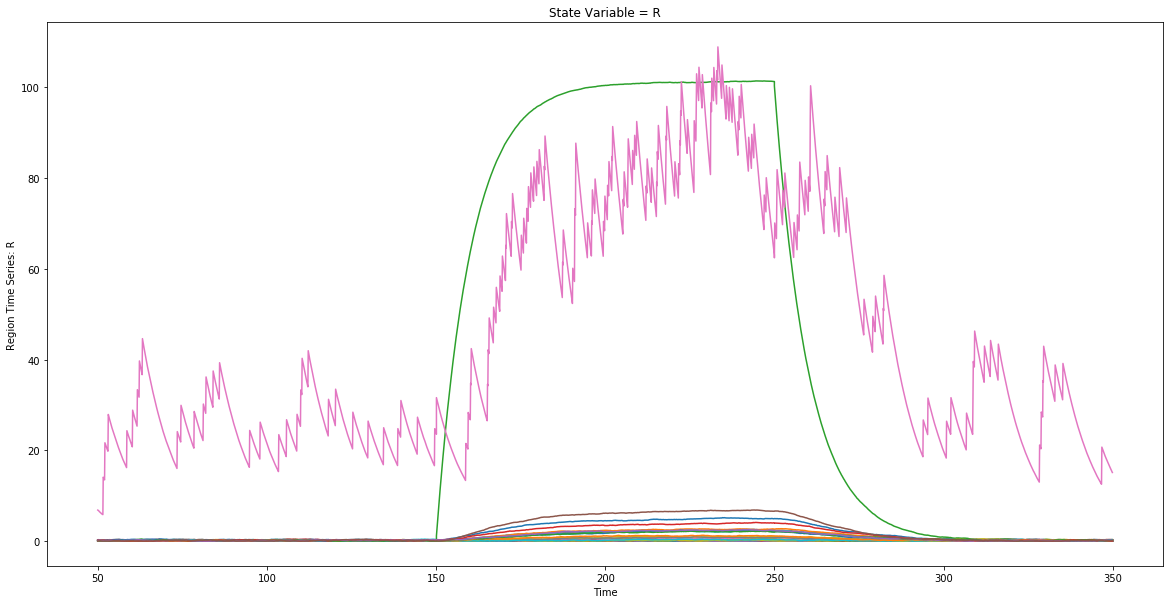

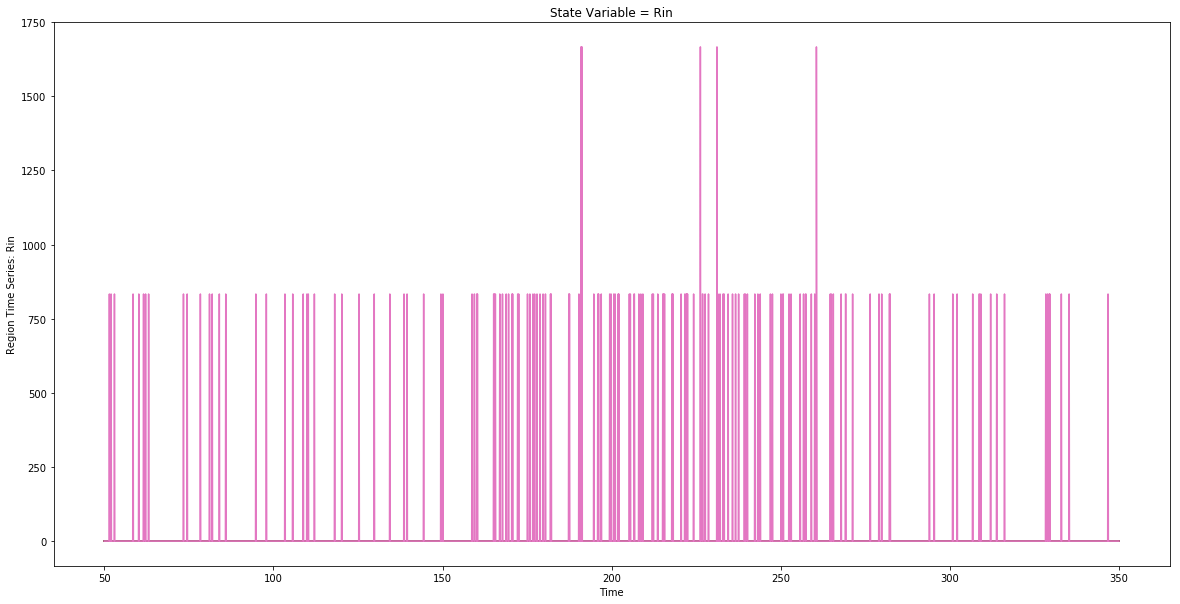

In [18]:
if source_ts is not None:
    # Plot TVB time series
    source_ts.plot_timeseries(plotter_config=plotter.config, per_variable=True, figsize=FIGSIZE, add_legend=False);

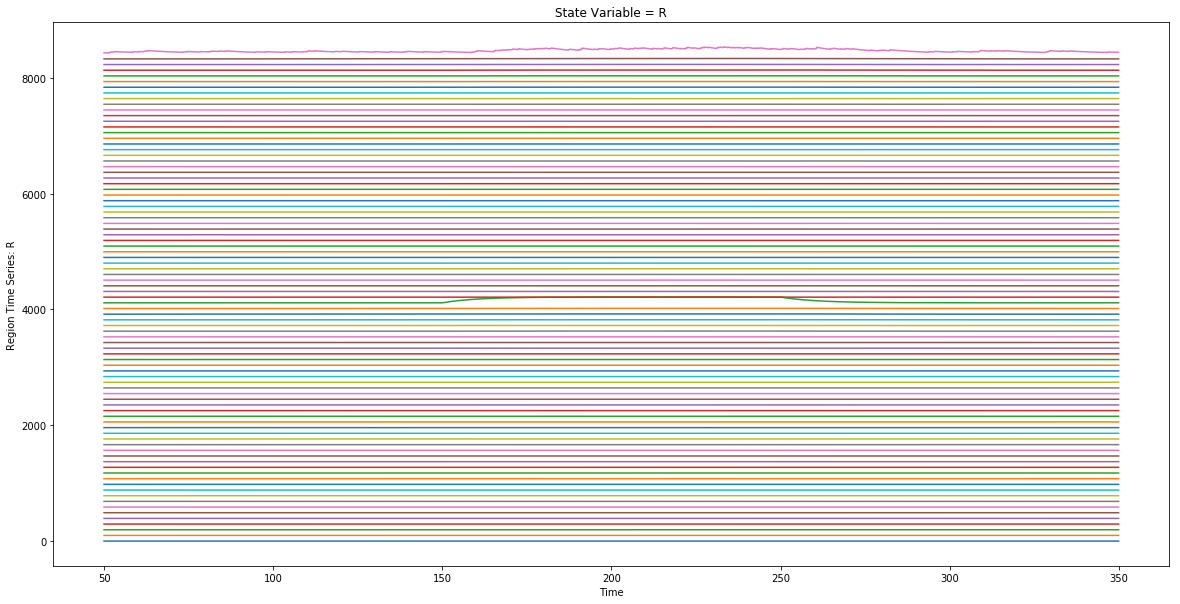

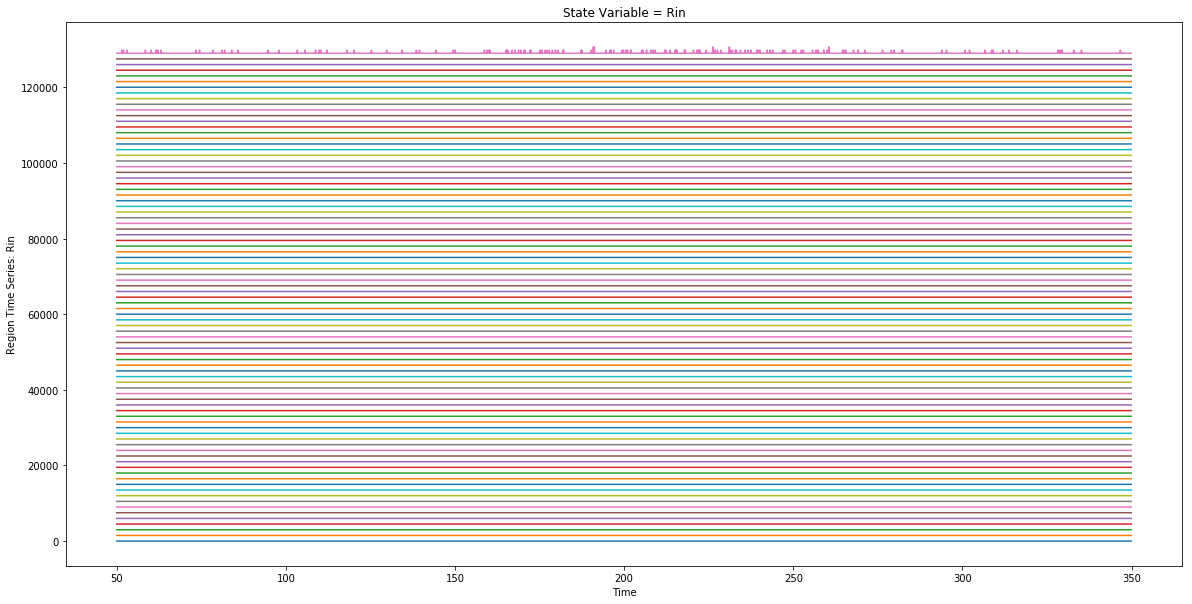

In [19]:
if source_ts is not None:
    # TVB time series raster plot:
    if source_ts.number_of_labels > 9:
        source_ts.plot_raster(plotter_config=plotter.config, per_variable=True, figsize=FIGSIZE, add_legend=False);

### Interactive time series plot

In [20]:
# # ...interactively as well
# # For interactive plotting:
# %matplotlib notebook 
# plotter.plot_timeseries_interactive(source_ts)

In [21]:
# source_ts[:, :, stim_node_id].plot_timeseries(plotter_config=plotter.config, per_variable=True, figsize=FIGSIZE,
#                                    figname="Stimulated region TVB Time Series");

2020-09-09 22:56:14,568 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-09-09 22:56:14,617 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-09-09 22:56:14,802 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


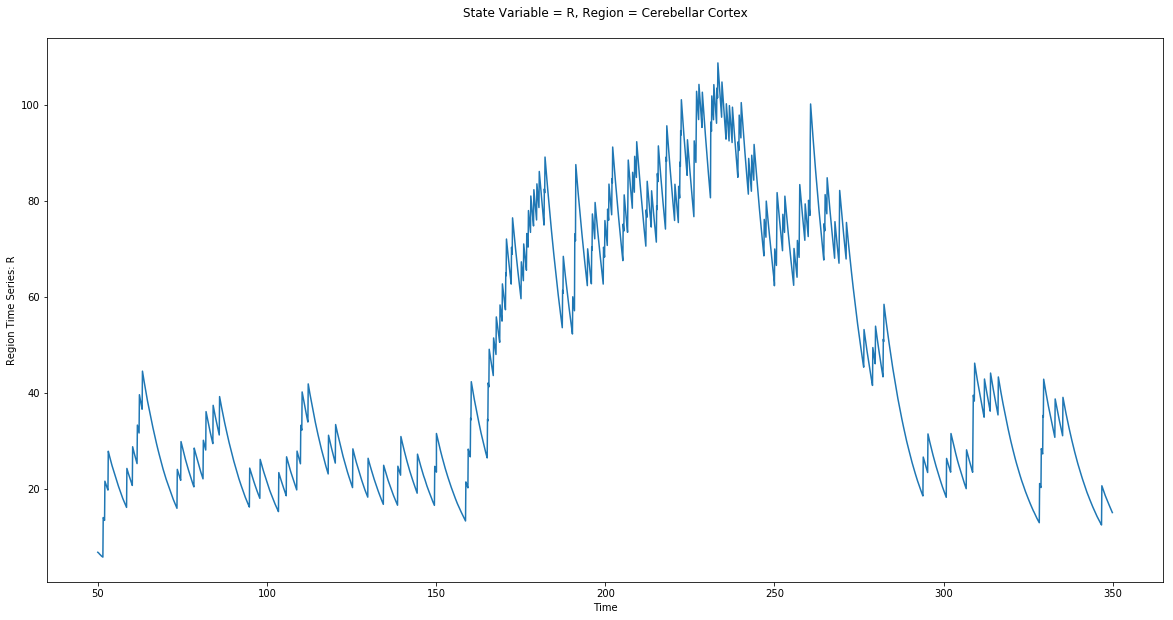

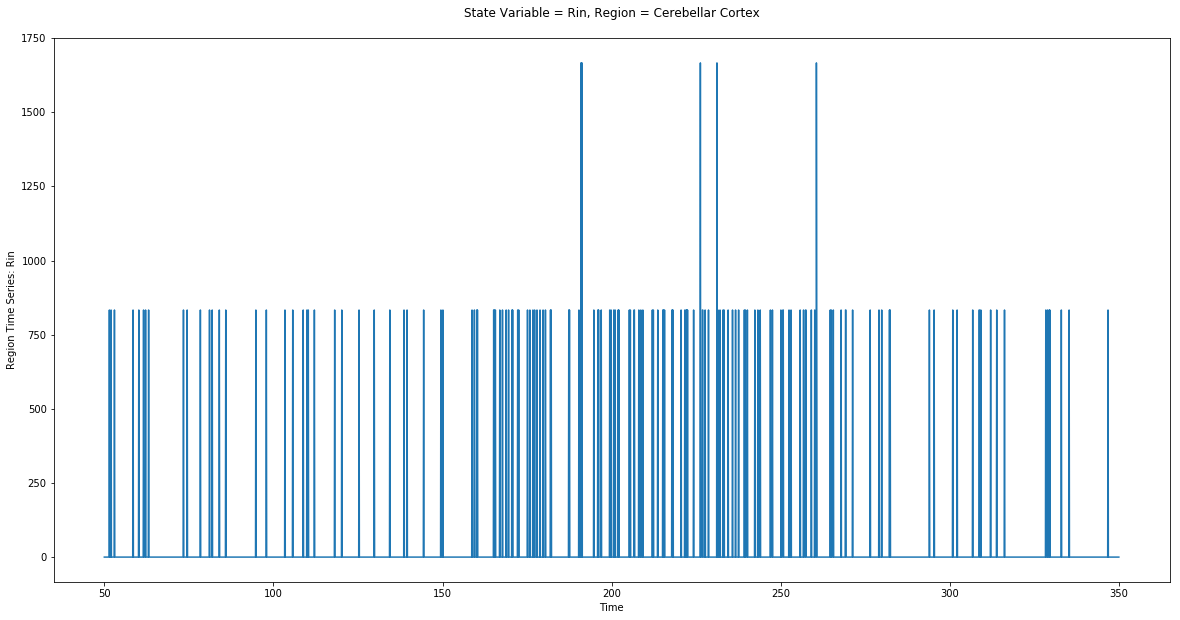

In [22]:
# Focus on the nodes modelled in NEST:
try:
    tvb_nest_model = simulator.tvb_spikeNet_interface
except:
    pass
source_ts_nest = None
if tvb_nest_model is not None:
    n_spiking_nodes = len(simulator.tvb_spikeNet_interface.spiking_nodes_ids)
    source_ts_nest = source_ts[:, :, simulator.tvb_spikeNet_interface.spiking_nodes_ids]
    source_ts_nest.plot_timeseries(plotter_config=plotter.config, per_variable=True, figsize=FIGSIZE,
                                   figname="Spiking nodes TVB Time Series");


In [23]:
# # Focus on the nodes modelled in NEST: raster plot
# if source_ts_nest is not None:
#     source_ts_nest.plot_raster(plotter_config=plotter.config, per_variable=True, figsize=FIGSIZE,
#                                figname="Spiking nodes TVB Time Series Raster");

### 5b. Results of TVB-NEST interface

### Plot population mean membrane potential time series

2020-09-09 22:56:16,159 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-09-09 22:56:16,211 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-09-09 22:56:16,451 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-09-09 22:56:16,662 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-09-09 22:56:16,887 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-09-09 22:56:17,113 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-09-09 22:56:17,351 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries lab

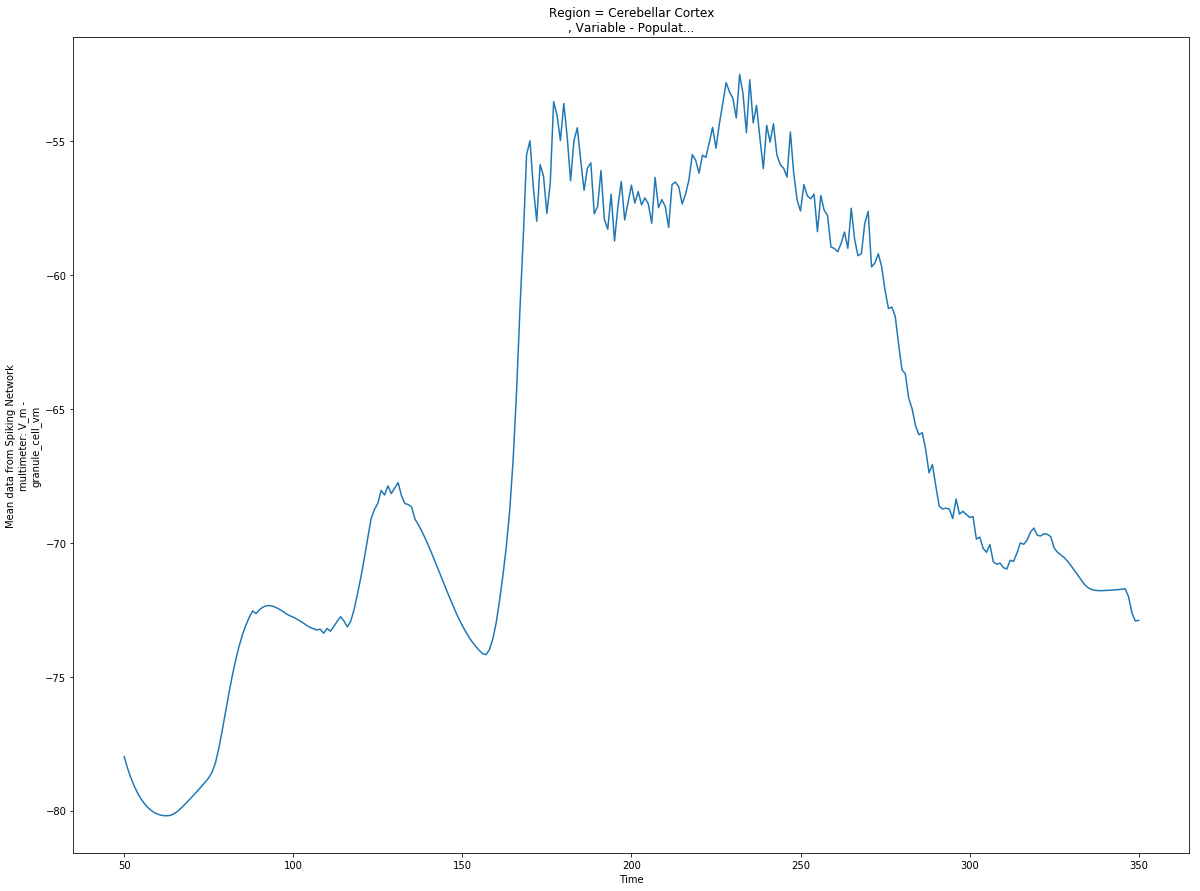

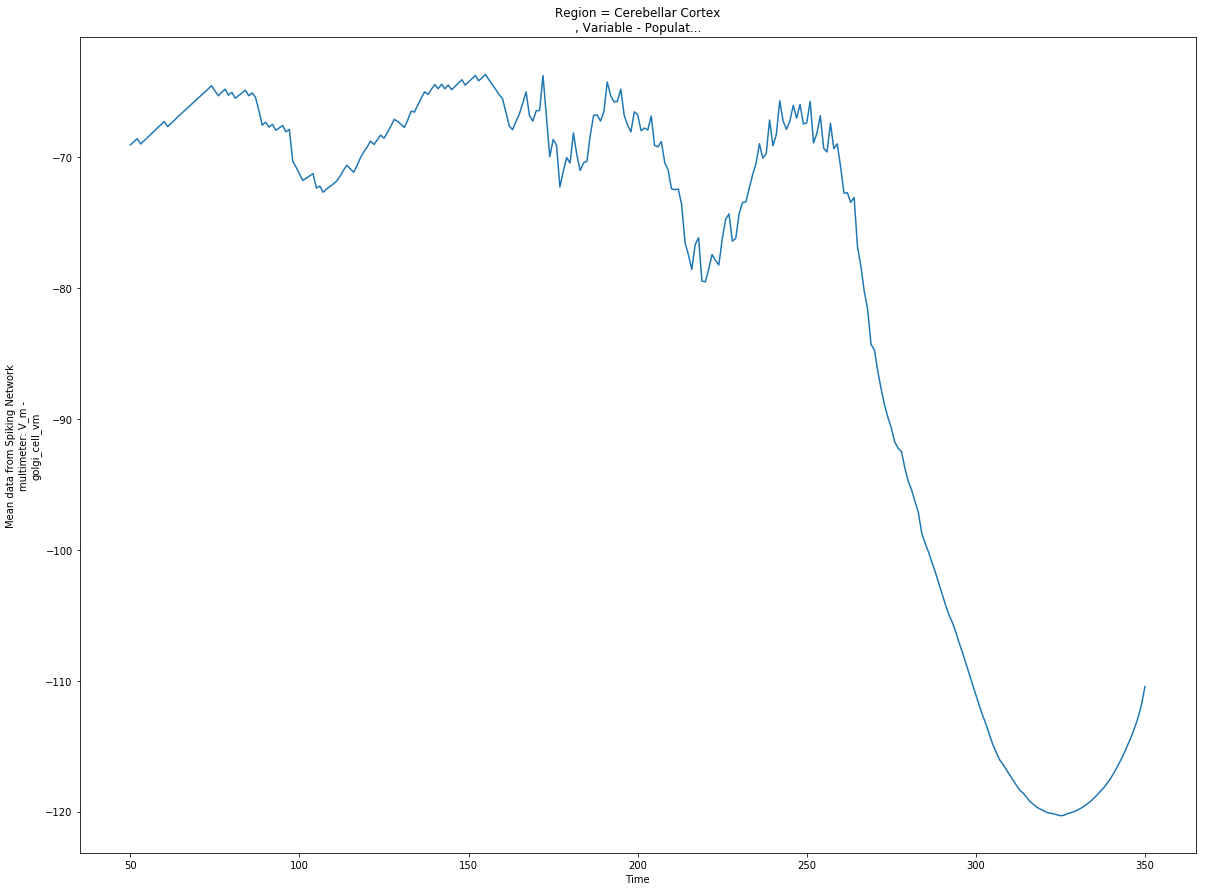

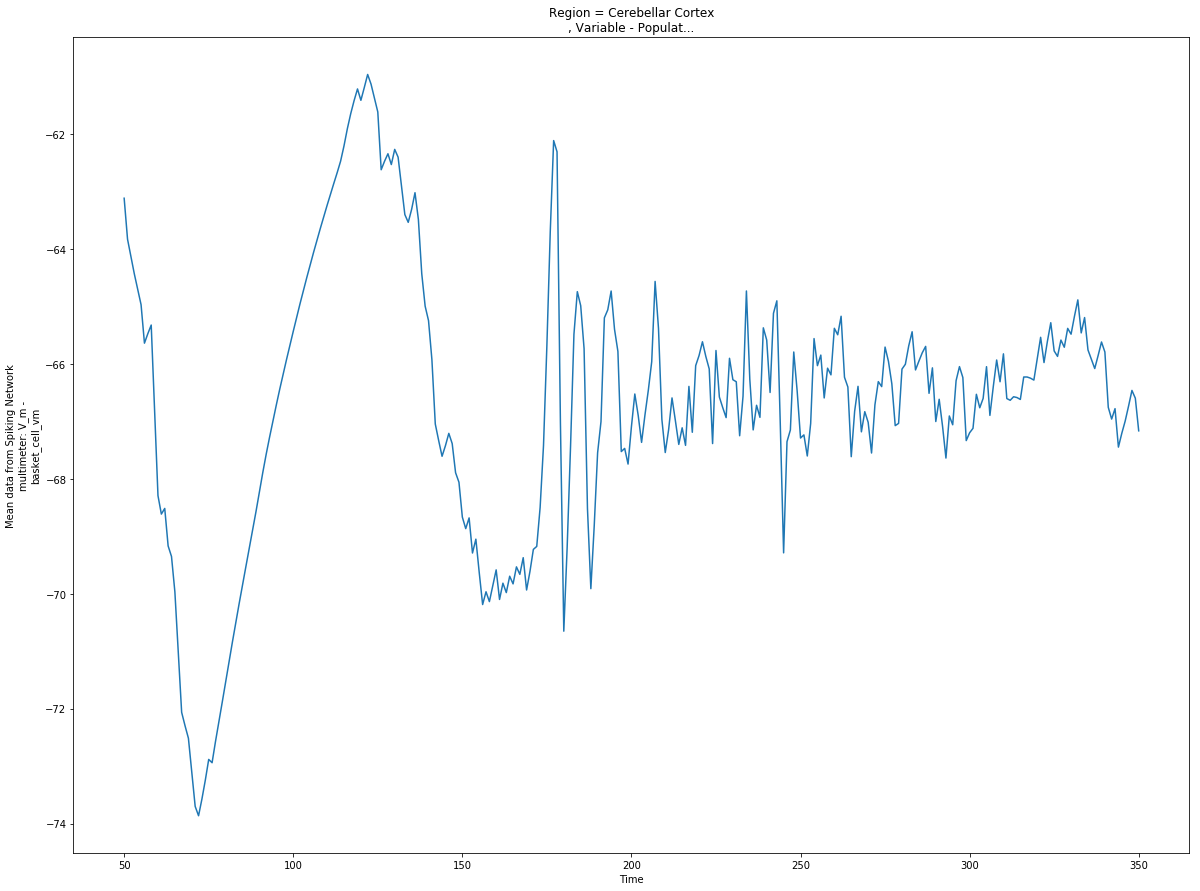

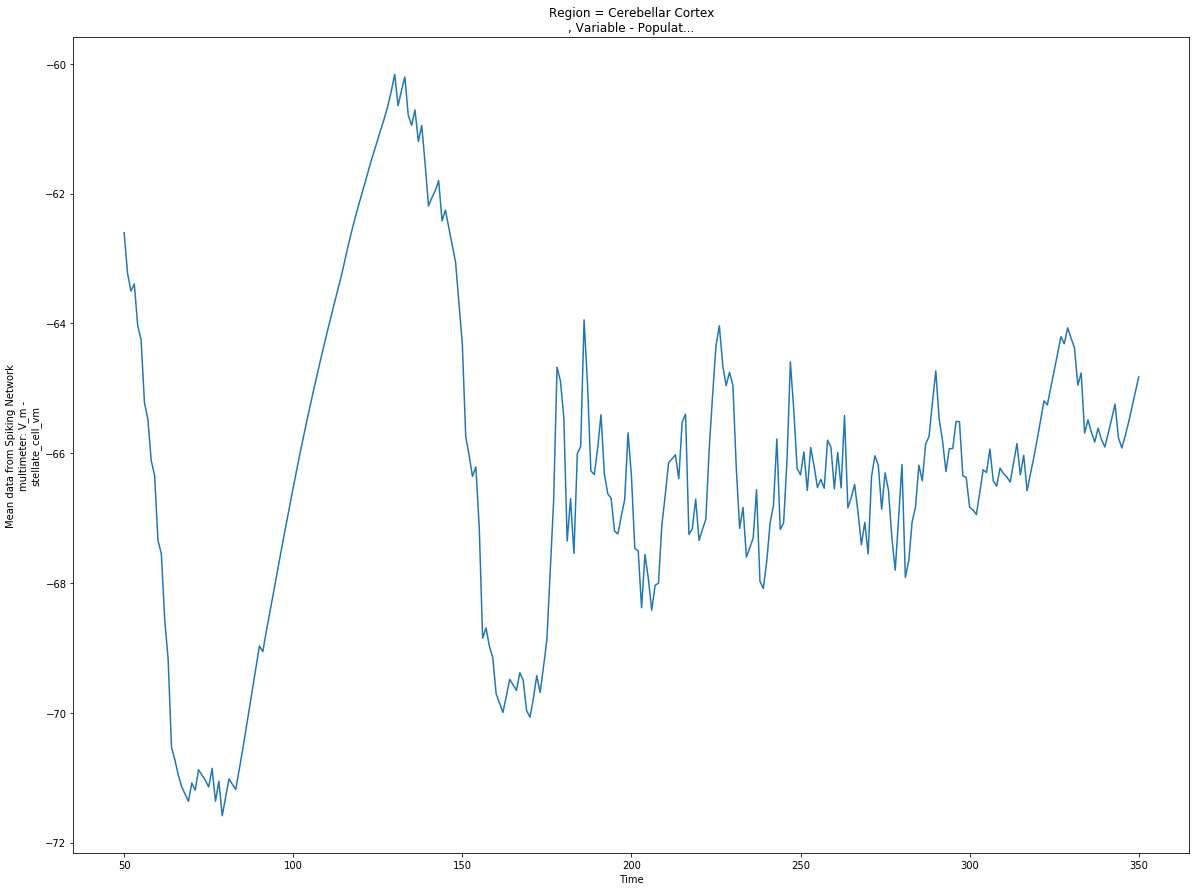

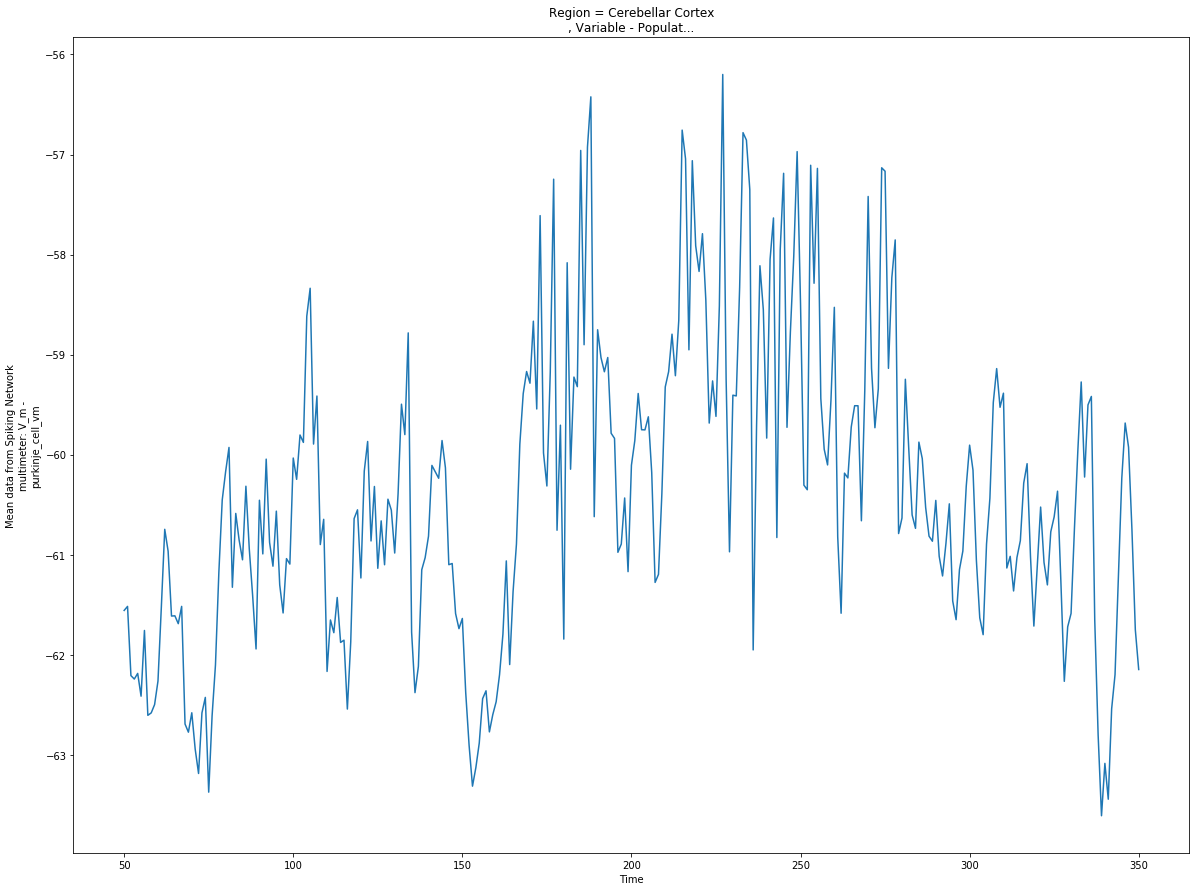

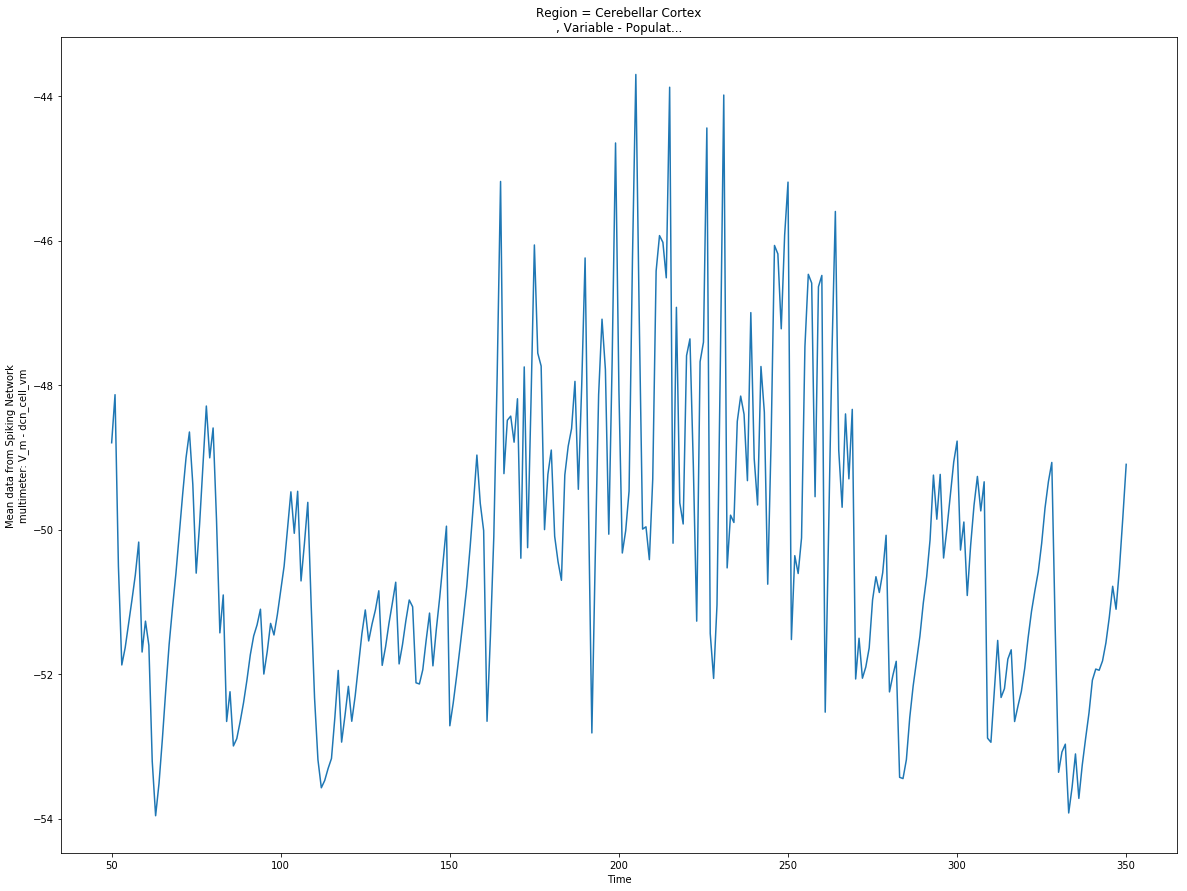

In [24]:
%matplotlib inline 
if tvb_nest_model is not None:
    tic = time.time()
    # Plot NEST multimeter variables
    # Get continuous state variables from NEST via interfaces to NEST multimeter devices
    # Get them directly as mean field quantities..
    multimeter_mean_data = \
        simulator.tvb_spikeNet_interface.get_mean_data_from_multimeter_to_TimeSeries(connectivity=simulator.connectivity)
    if transient:
        multimeter_mean_data = multimeter_mean_data[transient:]
    if multimeter_mean_data is not None and multimeter_mean_data.size > 0:
         plotter.plot_multimeter_timeseries(multimeter_mean_data, plot_per_variable=True,
                                            time_series_class=TimeSeriesXarray, time_series_args={},
                                            var_pop_join_str=" - ", default_population_label="population",
                                            figname="NEST region time series");
    if n_spiking_nodes > 3:
        plotter.plot_multimeter_raster(multimeter_mean_data, plot_per_variable=True,
                                       time_series_class=TimeSeriesXarray, time_series_args={},
                                       var_pop_join_str=" - ", default_population_label="population",
                                       figname="NEST region time series raster");
    print("\nRecovered and plotted TVB-NEST interface results in %f secs!" % (time.time() - tic))
    

### Plot spikes' raster and mean spike rate for NEST regions

In [25]:
# Plot spikes and mean field spike rates time series
# TOO SLOW FOR THE MOMENT!
# if tvb_nest_model is not None:
#     tic = time.time()
#     mf_rates_ts, spike_detectors = \
#             simulator.tvb_spikeNet_interface.get_mean_spikes_rates_to_TimeSeries(
#                 spikes_kernel_width=1.0,  # ms
#                 spikes_kernel_overlap=0.5, time=t, connectivity=simulator.connectivity)
#     if spike_detectors is not None and mf_rates_ts.size > 0:
#         plotter.plot_spike_detectors(spike_detectors, rates=mf_rates_ts, title='Population spikes and mean spike rate');
#      print("\nRecovered and plotted TVB-NEST interface mean field rate results in %f secs!" % (time.time() - tic))
    

### 5c. Results of NEST network
### Get per neuron NEST time series and plot them, as well as mean quantities

2020-09-09 22:56:19,708 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-09-09 22:56:19,739 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-09-09 22:56:19,782 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!


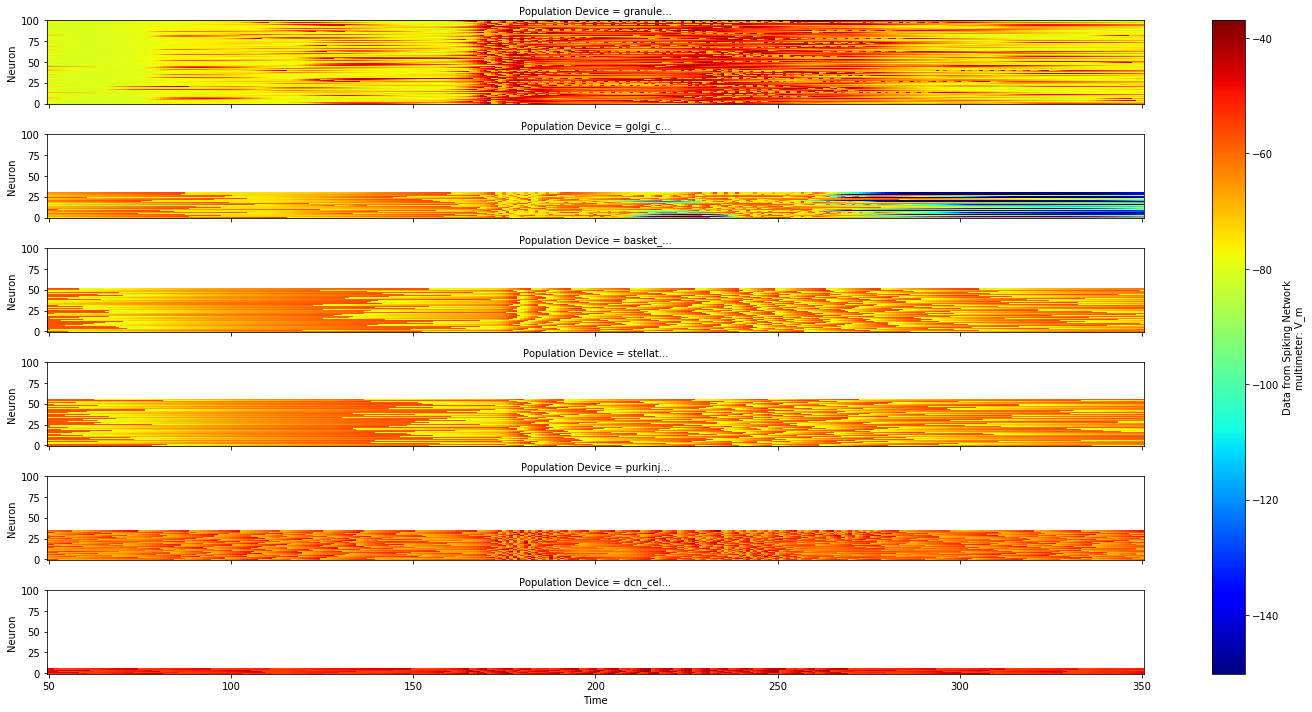

In [26]:
from xarray import DataArray
from tvb.contrib.scripts.utils.data_structures_utils import concatenate_heterogeneous_DataArrays
spiking_network = None
try:
    spiking_network = simulator.tvb_spikeNet_interface.spiking_network
except:
    spiking_network = nest_network
    n_spiking_nodes = len(nest_model_builder.nest_nodes_ids)

nest_ts = None
# TOO SLOW FOR THE MOMENT!
if spiking_network is not None:
    tic = time.time()
    # Time Series
    nest_ts = spiking_network.get_data_from_multimeter(mode="per_neuron")
    if not isinstance(nest_ts, DataArray):
        # assuming a pandas Series due to heterogeneity of populations in among brain regions:
        nest_ts = concatenate_heterogeneous_DataArrays(nest_ts, "Population",
                                                       transpose_dims=["Time", "Variable", 
                                                                       "Region", "Population", "Neuron"])
    nest_ts = TimeSeriesXarray(nest_ts, connectivity=simulator.connectivity)
    if transient:
        nest_ts = nest_ts[transient:]
    if n_spiking_nodes <= 3:
        # Regions in rows
        row = np.where(nest_ts.shape[2] > 1, nest_ts.dims[2], None).item()
        if row is None:
            # Populations in rows
            row = np.where(nest_ts.shape[3] > 1, nest_ts.dims[3], None).item()
            col = None
        else:
            # Populations in cols
            col = np.where(nest_ts.shape[3] > 1, nest_ts.dims[3], None).item()
        nest_ts.plot_map(y=nest_ts._data.dims[4], row=row, col=col,
                         per_variable=True,  cmap="jet", figsize=FIGSIZE, plotter_config=plotter.config);


2020-09-09 22:56:21,146 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!
2020-09-09 22:56:21,281 - WARNING - tvb.contrib.scripts.datatypes.time_series_xarray - Connectivity and RegionTimeSeries labels agreement failed!

Recovered and plotted NEST results in 2.361102 secs!


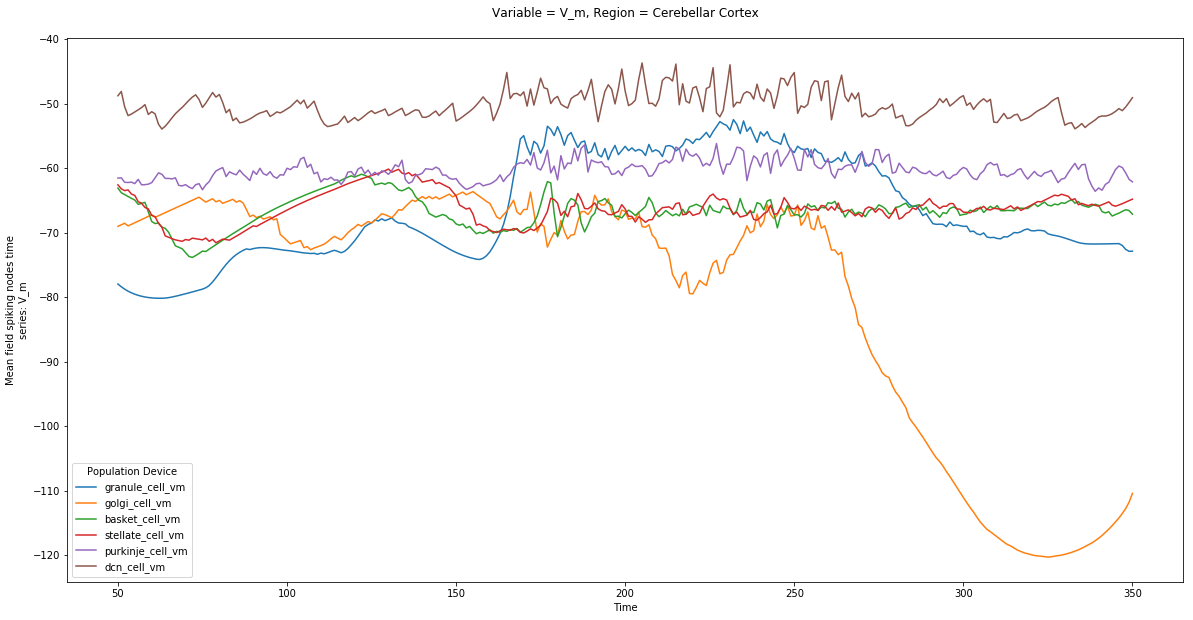

In [27]:
# Compute mean field
if nest_ts is not None:
    ts = TimeSeriesXarray(nest_ts._data.mean(axis=-1), connectivity=nest_ts.connectivity,
                          title="Mean field spiking nodes time series")
    if writer:
        writer.write_tvb_to_h5(TimeSeriesRegion().from_xarray_DataArray(ts._data, connectivity=ts.connectivity),
                               os.path.join(config.out.FOLDER_RES, ts.title)+".h5", recursive=False)
    # Plot mean field
    ts.plot_timeseries(plotter_config=plotter.config, per_variable=True, figsize=FIGSIZE)
    if n_spiking_nodes > 3:
        ts.plot_raster(plotter_config=plotter.config, per_variable=True, linestyle="--", alpha=0.5, linewidth=0.5);
    print("\nRecovered and plotted NEST results in %f secs!" % (time.time() - tic))
    

In [28]:
nest_spikes = None
if spiking_network is not None:
    from xarray import DataArray, concat

    tic = time.time()
    
    # Spikes
    nest_spikes = spiking_network.get_spikes(mode="events", return_type="Series", exclude_times=exclude_times)
    if writer:
        writer.write_object(nest_spikes.to_dict(), path=os.path.join(config.out.FOLDER_RES,  "NEST_Spikes") + ".h5")

    # Compute mean spike rates
    spike_rates = []
    if "t" in globals() and nest_ts is not None:
        t = nest_ts.time
        duration = (t[-1] - t[0])
    else:
        duration = simulation_length - transient
    duration  /= 1000   # in sec
    for i_pop, (pop_label, pop_spikes) in enumerate(nest_spikes.iteritems()):
        spike_rates.append([])
        reg_labels = []
        for reg_label, reg_spikes in pop_spikes.iteritems():
            reg_labels.append(reg_label)
            # rates (spikes/sec) =
            #   total_number_of_spikes (int) / total_time_duration (sec) / total_number_of_neurons_in_pop (int)
            spike_rates[-1].append(len(reg_spikes["times"]) / duration / populations_sizes[i_pop])
        spike_rates[-1] = np.array(spike_rates[-1])
        while spike_rates[-1].ndim < 2:
            spike_rates[-1] = spike_rates[-1][np.newaxis]
        spike_rates[-1] = DataArray(np.array(spike_rates[-1]), 
                                    dims=["Population", "Region"], name="NEST_spike_rates",
                                    coords={"Population": [pop_label], "Region": reg_labels})
    spike_rates = concat(spike_rates, spike_rates[-1].dims[0], fill_value=np.nan)
    print(spike_rates)
    if writer:
        writer.write_object(spike_rates.to_dict(), path=os.path.join(config.out.FOLDER_RES, spike_rates.name) + ".h5")

2020-09-09 22:56:22,267 - INFO - tvb_multiscale.core.io.h5_writer - Starting to write dict to: /home/docker/packages/tvb-multiscale/docs/documented_example_notebook/outputs_Cereb/res/NEST_Spikes.h5
2020-09-09 22:56:22,267 - INFO - tvb_multiscale.core.io.h5_writer - Starting to write dict to: /home/docker/packages/tvb-multiscale/docs/documented_example_notebook/outputs_Cereb/res/NEST_Spikes.h5
2020-09-09 22:56:22,284 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/mossy_fibers/Cerebellar Cortex
" (2 members)> dataset <class 'numpy.ndarray'> senders:
[49 50 22 46  1 16 24 39 36 37 21 41 43  7 27  3 25 44 18 23 37 38 34 10
 41 48 22  7  6  4 44 31 21 31 28 47 35 31 16 20 21 13  9 40 19 33 38 43
 10 23 34 16  7 36 40 26 33 21 29  5 26 50 41  9  2 26 31 48 40 33 12  1
  9  3 48 40 15 13 38 47 39 15 48 11 24 39 33 24 21  4 50  4 31 30 48  9
 14  8 12 17 28 24  4 39 49  4 12 43 21 48 25 29 16 16  8 38  8 33 18 20
 23 28 13 16 28 41 48 24 30 32 34  7 29 31 34 3

2020-09-09 22:56:22,302 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/mossy_fibers/Cerebellar Cortex
" (2 members)> dataset <class 'numpy.ndarray'> times:
[ 58.275  69.725  71.25   92.775  96.05   98.725 102.025 110.825 110.925
 111.95  114.875 150.925 151.925 153.425 154.4   155.2   156.55  156.925
 157.275 158.325 158.4   158.4   158.45  158.475 158.75  158.8   158.875
 159.35  159.7   159.775 160.175 160.225 160.275 160.375 160.425 160.55
 160.75  160.825 160.85  160.9   160.95  161.2   162.075 162.25  162.375
 162.425 162.525 162.575 163.225 163.525 163.75  163.775 163.95  164.075
 164.375 164.7   164.725 164.875 165.15  165.425 165.425 165.725 165.75
 166.1   166.275 166.65  166.85  167.675 168.55  168.85  169.175 169.225
 169.55  169.7   169.8   170.15  170.25  170.725 170.775 170.8   170.875
 170.95  171.125 171.275 171.35  171.4   171.725 171.875 171.9   172.175
 172.2   172.225 172.225 172.425 172.45  172.475 172.475 172.625 172.825
 172.9   

2020-09-09 22:56:22,364 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/golgi_cell_spikes/Cerebellar Cortex
" (2 members)> dataset <class 'numpy.ndarray'> senders:
[13265 13280 13260 13275 13276 13264 13263 13283 13284 13259 13257 13266
 13269 13261 13277 13255 13273 13258 13268 13281 13274 13282 13262 13278
 13271 13279 13256 13272 13265 13270 13267 13261 13260 13270 13263 13267
 13280 13281 13277 13276 13264 13275 13257 13283 13284 13269 13259 13274
 13271 13273 13266 13258 13262 13282 13268 13280 13278 13255 13260 13275
 13264 13276 13257 13283 13284 13271 13281 13261 13273 13259 13262 13263
 13280 13270 13279 13274 13269 13272 13267 13282 13275 13265 13260 13266
 13257 13264 13271 13276 13281 13284 13259 13283 13261 13278 13262 13263
 13268 13258 13280 13273 13255 13274 13256 13270 13275 13277 13260 13267
 13257 13269 13282 13271 13281 13264 13259 13261 13284 13276 13262 13263
 13283 13279 13280 13266 13274 13275 13273 13260 13257 13270 13271 13281


2020-09-09 22:56:22,393 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/basket_cell_spikes/Cerebellar Cortex
" (2 members)> dataset <class 'numpy.ndarray'> senders:
[13288 13301 13307 13317 13299 13293 13325 13286 13336 13327 13302 13328
 13315 13294 13313 13300 13316 13297 13295 13330 13322 13324 13310 13303
 13296 13311 13304 13308 13309 13292 13290 13332 13329 13298 13289 13291
 13287 13317 13334 13335 13318 13312 13301 13305 13306 13285 13325 13302
 13326 13304 13307 13310 13333 13293 13320 13311 13321 13314 13323 13294
 13319 13328 13331 13300 13327 13297 13330 13291 13296 13322 13288 13313
 13316 13286 13336 13315 13295 13298 13309 13329 13290 13303 13289 13332
 13299 13292 13324 13308 13317 13300 13334 13318 13301 13287 13294 13312
 13335 13310 13304 13326 13333 13302 13325 13306 13321 13285 13307 13311
 13313 13314 13327 13320 13331 13316 13319 13296 13315 13293 13330 13295
 13323 13305 13297 13298 13288 13322 13289 13299 13309 13291 13328 13336

2020-09-09 22:56:22,414 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/basket_cell_spikes/Cerebellar Cortex
" (2 members)> dataset <class 'numpy.ndarray'> times:
[ 50.325  50.7    51.8    52.975  53.025  54.55   55.625  55.725  58.2
  58.3    58.35   58.575  59.075  59.2    59.375  59.775  60.075  62.25
  62.9    63.225  64.25   64.675  65.4    65.55   65.575  66.475  66.7
  66.75   67.975  68.35   69.05   69.175  70.025  70.075  71.2    75.8
 119.925 122.425 123.1   124.225 125.45  125.6   125.875 128.875 130.675
 131.675 131.725 132.475 132.55  133.45  136.225 136.5   137.075 137.825
 138.    138.4   138.75  139.725 140.575 140.725 141.025 141.15  141.95
 142.275 143.4   146.275 147.275 147.95  148.95  149.175 149.575 150.15
 152.05  152.125 154.35  154.6   155.075 155.45  157.25  160.15  160.2
 162.25  164.8   166.925 168.6   168.925 171.525 175.75  176.825 176.925
 177.    177.225 177.3   177.45  177.675 177.8   177.875 178.05  178.075
 178.275 178

2020-09-09 22:56:22,429 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/stellate_cell_spikes/Cerebellar Cortex
" (2 members)> dataset <class 'numpy.ndarray'> senders:
[13383 13385 13437 13388 13412 13444 13428 13377 13365 13409 13436 13360
 13417 13395 13381 13386 13376 13369 13382 13434 13441 13346 13363 13418
 13392 13358 13429 13420 13361 13401 13423 13348 13419 13430 13371 13355
 13413 13352 13410 13402 13447 13364 13391 13433 13347 13397 13399 13393
 13400 13435 13449 13407 13373 13394 13362 13403 13384 13406 13440 13375
 13378 13374 13357 13353 13416 13422 13337 13356 13421 13425 13426 13339
 13389 13338 13445 13396 13344 13341 13438 13340 13411 13368 13442 13424
 13398 13444 13390 13405 13349 13432 13414 13379 13350 13415 13354 13377
 13447 13409 13412 13434 13388 13443 13345 13369 13351 13370 13352 13356
 13428 13358 13408 13427 13383 13380 13431 13342 13359 13446 13387 13382
 13372 13448 13367 13385 13364 13436 13420 13391 13365 13395 13371 134

2020-09-09 22:56:22,459 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/stellate_cell_spikes/Cerebellar Cortex
" (2 members)> dataset <class 'numpy.ndarray'> times:
[ 50.025  50.5    51.25   51.3    51.4    52.25   52.975  53.025  53.8
  54.375  54.6    54.85   55.4    55.6    55.725  55.825  56.075  56.45
  56.725  57.225  57.25   57.575  57.825  58.2    58.425  58.5    58.5
  58.75   59.35   59.45   59.8    60.5    60.575  60.75   61.05   61.375
  61.55   61.575  61.725  61.875  62.5    62.525  62.775  63.4    63.5
  63.6    63.9    64.175  64.475  65.025  65.35   66.675  67.625  67.7
  68.35   68.35   68.5    68.775  70.6    70.95   71.175  72.25   72.775
  73.15   73.25   74.     74.375  76.05   76.3    76.55   77.5    78.075
  78.075  79.375  81.225  81.825  82.     82.275  85.15   87.2    90.65
  91.775  92.725 109.7   121.975 126.525 129.375 130.675 130.975 132.5
 132.8   133.05  133.925 133.925 134.125 134.625 136.025 136.475 136.775
 137.5   13

2020-09-09 22:56:22,469 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/purkinje_cell_spikes/Cerebellar Cortex
" (2 members)> dataset <class 'numpy.ndarray'> senders:
[13477 13479 13483 ... 13481 13476 13453] !

2020-09-09 22:56:22,475 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/purkinje_cell_spikes/Cerebellar Cortex
" (2 members)> dataset <class 'numpy.ndarray'> times:
[ 50.3    50.875  51.15  ... 349.1   349.65  349.7  ] !

2020-09-09 22:56:22,475 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/purkinje_cell_spikes/Cerebellar Cortex
" (2 members)> dataset <class 'numpy.ndarray'> times:
[ 50.3    50.875  51.15  ... 349.1   349.65  349.7  ] !

2020-09-09 22:56:22,488 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 group "/dcn_cell_spikes/Cerebellar Cortex
" (2 members)> dataset <class 'numpy.ndarray'> senders:
[13490 13486 13488 13487 13485 13489 13486 13488 1

2020-09-09 22:56:22,826 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 file "NEST_spike_rates.h5" (mode r+)> dataset <class 'numpy.ndarray'> data:
[[ 42.6       ]
 [ 42.8886693 ]
 [ 45.12877297]
 [ 49.88888889]
 [ 39.67948718]
 [ 28.7020649 ]
 [114.38095238]
 [ 91.66666667]] !

2020-09-09 22:56:22,826 - WARNING - tvb_multiscale.core.io.h5_writer - 
Failed to write to <HDF5 file "NEST_spike_rates.h5" (mode r+)> dataset <class 'numpy.ndarray'> data:
[[ 42.6       ]
 [ 42.8886693 ]
 [ 45.12877297]
 [ 49.88888889]
 [ 39.67948718]
 [ 28.7020649 ]
 [114.38095238]
 [ 91.66666667]] !

2020-09-09 22:56:22,835 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'tuple'> dims to h5 file as a numpy array dataset !

2020-09-09 22:56:22,835 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'tuple'> dims to h5 file as a numpy array dataset !

2020-09-09 22:56:22,839 - WARNING - tvb_multiscale.core.io.h5_writer - 
Writing <class 'list'> data to h5 file


Recovered and plotted NEST spikes and computed spike rates in 1.781348 secs!


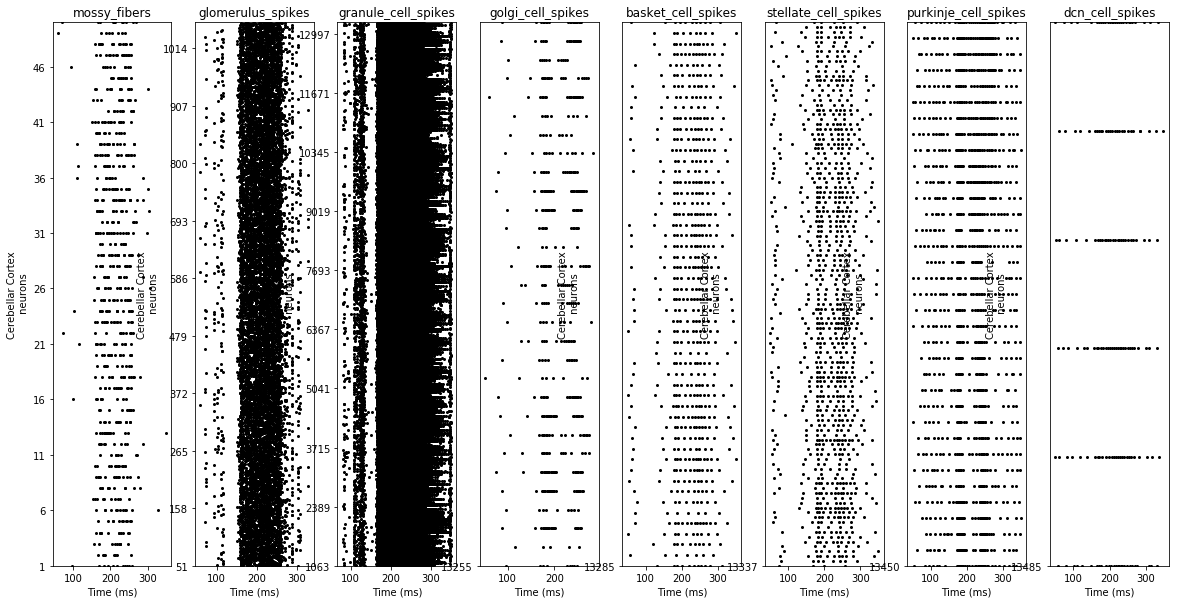

In [29]:
# Plot spikes
if nest_spikes is not None:
    plotter.plot_spike_events(nest_spikes, figsize=FIGSIZE);
    print("\nRecovered and plotted NEST spikes and computed spike rates in %f secs!" % (time.time() - tic))

# References

1 Paula Sanz Leon, Stuart A. Knock, M. Marmaduke Woodman, Lia Domide, <br>
  Jochen Mersmann, Anthony R. McIntosh, Viktor Jirsa (2013) <br>
  The Virtual Brain: a simulator of primate brain network dynamics. <br>
  Frontiers in Neuroinformatics (7:10. doi: 10.3389/fninf.2013.00010) <br>
  https://www.thevirtualbrain.org/tvb/zwei <br>
  https://github.com/the-virtual-brain <br>

2 Ritter P, Schirner M, McIntosh AR, Jirsa VK. 2013.  <br>
  The Virtual Brain integrates computational modeling  <br>
  and multimodal neuroimaging. Brain Connectivity 3:121–145. <br>

3 Jordan, Jakob; Mørk, Håkon; Vennemo, Stine Brekke;   Terhorst, Dennis; Peyser, <br>
  Alexander; Ippen, Tammo; Deepu, Rajalekshmi;   Eppler, Jochen Martin; <br>
  van Meegen, Alexander;   Kunkel, Susanne; Sinha, Ankur; Fardet, Tanguy; Diaz, <br>
  Sandra; Morrison, Abigail; Schenck, Wolfram; Dahmen, David;   Pronold, Jari; <br>
  Stapmanns, Jonas;   Trensch, Guido; Spreizer, Sebastian;   Mitchell, Jessica; <br>
  Graber, Steffen; Senk, Johanna; Linssen, Charl; Hahne, Jan; Serenko, Alexey; <br>
  Naoumenko, Daniel; Thomson, Eric;   Kitayama, Itaru; Berns, Sebastian;   <br>
  Plesser, Hans Ekkehard <br>
  NEST is a simulator for spiking neural network models that focuses <br>
  on the dynamics, size and structure of neural systems rather than on <br>
  the exact morphology of individual neurons. <br>
  For further information, visit http://www.nest-simulator.org. <br>
  The release notes for this release are available at  <br>
  https://github.com/nest/nest-simulator/releases/tag/v2.18.0 <br>

In [30]:
list(zip(dict(spike_rates.coords)["Population"].values.tolist(), spike_rates.values.tolist()))

[('mossy_fibers', [42.6]),
 ('glomerulus_spikes', [42.88866930171278]),
 ('granule_cell_spikes', [45.128772965879264]),
 ('golgi_cell_spikes', [49.88888888888889]),
 ('basket_cell_spikes', [39.67948717948718]),
 ('stellate_cell_spikes', [28.702064896755164]),
 ('purkinje_cell_spikes', [114.38095238095238]),
 ('dcn_cell_spikes', [91.66666666666667])]